# 0. Functions for later usage

### 0.0 Import libraries

In [208]:
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from collections import defaultdict
from colorama import Back, Fore
import inspect
from sklearn.model_selection import train_test_split
from tensorflow.keras import models, layers, optimizers, callbacks
from tensorflow.keras.utils import plot_model
import inspect
import chardet
import sys
import time
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,precision_recall_curve, roc_curve, auc
import seaborn as sns


### 0.1 Function 1: display_filtered_images -> this function displays different pictures from our dataset

In [209]:
def display_filtered_images(df, age=None, ethnicity=None, gender=None, num_images=8, figsize=(20, 4)):
    """
    Display images filtered by age, ethnicity, and gender.
    
    Parameters:
    - df: DataFrame containing the image data and labels.
    - age: Filter for the age of the individuals (int or None).
    - ethnicity: Filter for the ethnicity of the individuals (int or None).
    - gender: Filter for the gender of the individuals (int or None).
    - num_images: Number of images to display.
    - figsize: Size of the figure.
    """
    
    # Apply filters
    filtered_df = df
    if age is not None:
        filtered_df = filtered_df[filtered_df['age'] == age]
    if ethnicity is not None:
        filtered_df = filtered_df[filtered_df['ethnicity'] == ethnicity]
    if gender is not None:
        filtered_df = filtered_df[filtered_df['gender'] == gender]
    
    # Ensure we don't try to display more images than available after filtering
    num_images = min(len(filtered_df), num_images)
    
    # Set up the plot
    fig, axes = plt.subplots(1, num_images, figsize=figsize)
    for i in range(num_images):
        # Directly use the pixel array if it's already in the correct format
        img_array = filtered_df.iloc[i]['pixels']
        if isinstance(img_array, np.ndarray):
            img_array = img_array.reshape(48, 48)  # Use directly if it's a numpy array
        else:
            img_array = img_array.numpy().reshape(48, 48)  # Convert to numpy array and then reshape
        ax = axes[i] if num_images > 1 else axes  # Handle case of num_images == 1
        # Display the image
        ax.imshow(img_array, cmap='gray')
        # Optionally, set a title with more information
        ax.set_title(f"Age: {filtered_df.iloc[i]['age']}\nEthnicity: {filtered_df.iloc[i]['ethnicity']}\nGender: {filtered_df.iloc[i]['gender']}")
        ax.axis('off')
    plt.tight_layout()
    plt.show()


### 0.2 Function 2: evaluate_neural_network -> this function evaluates the model performance

In [210]:
def evaluate_neural_network(model, val_dataset, history):
    # Predict the labels for the validation set
    y_pred_probs = model.predict(val_dataset)
    y_pred = (y_pred_probs > 0.5).astype(int).reshape(-1)

    # Extract true labels from the validation dataset
    y_true = np.concatenate([np.array([y.numpy()]) for x, y in val_dataset.unbatch()], axis=0)

    # Print the classification report for all metrics
    print(classification_report(y_true, y_pred, target_names=['Class 0', 'Class 1']))

    # Calculate and print the accuracy
    accuracy = accuracy_score(y_true, y_pred)
    print(f"Accuracy: {accuracy * 100:.2f}%")

    # Set up the subplot grid
    fig, axs = plt.subplots(3, 2, figsize=(14, 15))
    
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axs[0, 0])
    axs[0, 0].set_title('Confusion Matrix')
    axs[0, 0].set_xlabel('Predicted')
    axs[0, 0].set_ylabel('True')

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_true, y_pred_probs)
    axs[1, 0].plot(recall, precision, marker='.')
    axs[1, 0].set_title('Precision-Recall Curve')
    axs[1, 0].set_xlabel('Recall')
    axs[1, 0].set_ylabel('Precision')

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_pred_probs)
    roc_auc = auc(fpr, tpr)
    axs[1, 1].plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    axs[1, 1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    axs[1, 1].set_xlabel('False Positive Rate')
    axs[1, 1].set_ylabel('True Positive Rate')
    axs[1, 1].set_title('Receiver Operating Characteristic')
    axs[1, 1].legend(loc="lower right")

    # Training & validation accuracy values
    axs[2, 0].plot(history.history['binary_accuracy'])
    axs[2, 0].plot(history.history['val_binary_accuracy'])
    axs[2, 0].set_title('Model Binary Accuracy')
    axs[2, 0].set_ylabel('Binary Accuracy')
    axs[2, 0].set_xlabel('Epoch')
    axs[2, 0].legend(['Train', 'Val'], loc='upper left')

    # Training & validation loss values
    axs[2, 1].plot(history.history['loss'])
    axs[2, 1].plot(history.history['val_loss'])
    axs[2, 1].set_title('Model Loss')
    axs[2, 1].set_ylabel('Loss')
    axs[2, 1].set_xlabel('Epoch')
    axs[2, 1].legend(['Train', 'Val'], loc='upper left')

    plt.tight_layout()
    plt.show()

# To use this function, call it with the appropriate model, validation dataset, and training history:
# evaluate_neural_network(model_v4, val_dataset_1, history)


### 0.3 Function 3: calculate_combined_misclassification_info -> this function displays the absolute and relative volumes of missclassified instances/pictures broken down by age, gender and ethnicity.

In [211]:
def calculate_combined_misclassification_info(y_true, y_pred, data, category_names, age_bucket_size=5):
    """
    Calculate and print the misclassification rates and distribution for each label in each category,
    with ages bucketed into specified tranches.

    Parameters:
    - y_true: array-like of true labels
    - y_pred: array-like of predicted labels
    - data: DataFrame containing the category labels
    - category_names: list of column names in the DataFrame that are categories
    - age_bucket_size: size of the age buckets (default is 5 years)
    """
    # Initialize dictionaries to count total and misclassified instances per label
    total_counts = {name: defaultdict(int) for name in category_names}
    misclassified_counts = {name: defaultdict(int) for name in category_names}

    # Function to bucket the age
    def bucket_age(age):
        return f"{age // age_bucket_size * age_bucket_size}-{(age // age_bucket_size + 1) * age_bucket_size - 1}"

    # Iterate over the dataset and populate the counts
    for i, (true, pred) in enumerate(zip(y_true, y_pred)):
        for name in category_names:
            category_value = data.iloc[i][name]
            if name == 'age':
                category_value = bucket_age(category_value)
                
            total_counts[name][category_value] += 1
            if true != pred:
                misclassified_counts[name][category_value] += 1

    # Now calculate and print the misclassification rates and distribution
    for name in category_names:
        print(f"\n{name} - Misclassification rates:")
        for category_value, count in sorted(total_counts[name].items()):
            misclassified = misclassified_counts[name][category_value]
            total = count
            percentage = (misclassified / total) * 100 if total > 0 else 0
            print(f"  {category_value}: Total = {total}, Misclassified = {misclassified} ({percentage:.2f}%)")

        print(f"\n{name} - Misclassification distribution:")
        total_misclassified = sum(misclassified_counts[name].values())
        for category_value, misclassified in sorted(misclassified_counts[name].items()):
            distribution_percentage = (misclassified / total_misclassified) * 100 if total_misclassified > 0 else 0
            print(f"  {category_value}: Misclassified = {misclassified} ({distribution_percentage:.2f}%) of Total Misclassified = {total_misclassified}")


## Identifying the device (either CPU or GPU) used with Keras & Tensorflow

https://www.tensorflow.org/api_docs/python/tf/config/list_physical_devices

This line of code is used to list all the physical GPU devices that are available for TensorFlow to use:

```python
print("Is a GPU available: ", tf.config.list_physical_devices('GPU'))
```

https://www.tensorflow.org/api_docs/python/tf/config/experimental

```python
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
```

In [212]:
# Check if TensorFlow can access the GPU
print("Is a GPU available: ", tf.config.list_physical_devices('GPU'))
# Print the number of GPUs available
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Is a GPU available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs Available:  1


https://www.tensorflow.org/api_docs/python/tf/config/experimental/set_memory_growth

This line of code is enabling memory growth for the first GPU device available for TensorFlow to use.

Memory growth allows TensorFlow to allocate GPU memory based on runtime needs, rather than allocating all available GPU memory upfront. 

```python
tf.config.experimental.set_memory_growth(gpus[0], True)
```


In [213]:
# Check for GPU availability
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    try:
        # Prevent TensorFlow from initializing all of the GPU memory at once
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        # Catch the runtime error if memory growth is set after GPU initialization
        print(e)
    
    device_name = tf.test.gpu_device_name()
    if device_name:
        print(f"OK: Using GPU: {device_name}")
    else:
        print("OK: GPU found, but no device name identified.")
else:
    print("KO: Using CPU")

OK: Using GPU: /device:GPU:0


## 1. We detect the file encoding
    ## age_gender.csv -> The detected encoding of the file is: ascii

In [214]:
def detect_file_encoding(file_path):
    """Detect the encoding of a given file."""
    with open(file_path, 'rb') as file:
        result = chardet.detect(file.read())
    return result['encoding']

# Example usage:
file_path = 'C:\\Users\\fercv\\OneDrive\\Desktop\\\AI_Master_Degree\\5_Deep_Learning\\data\\age_gender.csv'
detected_encoding = detect_file_encoding(file_path)

print(f'{Back.RED}The detected encoding of the file is:{Back.RESET}',
    f"\n{Back.BLUE}{detected_encoding}{Back.RESET}")

The detected encoding of the file is: 
ascii


## 2. We load our built-in functions for EDA

In [215]:
sys.path.append('C:\\Users\\fercv\\OneDrive\\Desktop\\Python\\00_Basics')
from Glimpse_20231230_v1 import DataFrameGlimpser
all_members = inspect.getmembers(DataFrameGlimpser)
function_members = [member for member in all_members if inspect.isfunction(member[1])]
for name, func in function_members:
    print(name)

print(f'{Back.RED}DataFrameGlimpser type:{Back.RESET}',
    f"\n{Back.BLUE}{type(DataFrameGlimpser)}{Back.RESET}")

__init__
calculate_additional_statistics
calculate_correlation_matrix
calculate_memory_savings
color_cells
display_comprehensive_statistics
display_correlation_matrix
display_custom_correlation_matrix
display_head_and_tail
display_html
display_index_information
display_info
display_missing_values
display_shape
display_summary_statistics
display_unique_values
generate_outlier_removal_snippet
glimpse
highlight_mad
highlight_outliers
highlight_variance
identify_potential_primary_keys
plot_missing_values_bar_chart
remove_outliers
set_df_name
suggest_and_display_data_type_changes
suggest_columns_to_drop
summarize_and_display_correlations
DataFrameGlimpser type: 
<class 'type'>


In [216]:
from Visualise_Data_20240217_v3 import DataVisualizer

all_members = inspect.getmembers(DataVisualizer)
function_members = [member for member in all_members if inspect.isfunction(member[1])]
for name, func in function_members:
    print(name)
    
print(f'{Back.RED}DataVisualizer type:{Back.RESET}',
    f"\n{Back.BLUE}{type(DataVisualizer)}{Back.RESET}")

__init__
reorder_categories
set_custom_palette
visualize_all
visualize_box_violin_plots
visualize_correlation_matrix
visualize_joint_plots
visualize_kdeplots
visualize_lm_line_plots
visualize_pairplots
visualize_strip_plots
DataVisualizer type: 
<class 'type'>


## 3. We load the dataset and perfom the EDA

In [217]:
#We load the data
age_gender_data = pd.read_csv(file_path, delimiter=',', encoding=detected_encoding)

In [218]:
print(f'{Back.RED}age_gender_data type:{Back.RESET}',
    f"\n{Back.BLUE}{type(age_gender_data)}{Back.RESET}")

age_gender_data type: 
<class 'pandas.core.frame.DataFrame'>


### 3.1 We understand the dataset structure, missing values and unique values for each variable

In [219]:
glimpser = DataFrameGlimpser(age_gender_data)
#glimpser.set_df_name('age_gender_data')  # Optional: Set a custom name
#glimpser.glimpse()
glimpser.display_head_and_tail()
glimpser.display_missing_values()
glimpser.display_unique_values()


,age,ethnicity,gender,img_name,pixels
0,1,2,0,20161219203650636.jpg.chip.jpg,129 128 128 126 127 130 133 135 139 142 145 14...
1,1,2,0,20161219222752047.jpg.chip.jpg,164 74 111 168 169 171 175 182 184 188 193 199...
2,1,2,0,20161219222832191.jpg.chip.jpg,67 70 71 70 69 67 70 79 90 103 116 132 145 155...
3,1,2,0,20161220144911423.jpg.chip.jpg,193 197 198 200 199 200 202 203 204 205 208 21...
4,1,2,0,20161220144914327.jpg.chip.jpg,202 205 209 210 209 209 210 211 212 214 218 21...


,age,ethnicity,gender,img_name,pixels
23700,99,0,1,20170120221920654.jpg.chip.jpg,127 100 94 81 77 77 74 99 102 98 128 145 160 1...
23701,99,1,1,20170120134639935.jpg.chip.jpg,23 28 32 35 42 47 68 85 98 103 113 117 130 129...
23702,99,2,1,20170110182418864.jpg.chip.jpg,59 50 37 40 34 19 30 101 156 170 177 184 187 1...
23703,99,2,1,20170117195405372.jpg.chip.jpg,45 108 120 156 206 197 140 180 191 199 204 207...
23704,99,0,1,20170110182052119.jpg.chip.jpg,156 161 160 165 170 173 166 177 183 191 187 18...


Series([], dtype: int64)

age            104
ethnicity        5
gender           2
img_name     23479
pixels       23315
dtype: int64

In [220]:
print(age_gender_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23705 entries, 0 to 23704
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        23705 non-null  int64 
 1   ethnicity  23705 non-null  int64 
 2   gender     23705 non-null  int64 
 3   img_name   23705 non-null  object
 4   pixels     23705 non-null  object
dtypes: int64(3), object(2)
memory usage: 926.1+ KB
None


### 3.2. We understand the images pixels size

In [221]:
# Assuming age_gender_data['pixels'][0] is a string of pixel intensities
num_pixels = len(age_gender_data['pixels'][0].split())
image_size = int(num_pixels ** 0.5)  # Assuming the images are square

print(f'{Back.RED}Each image is:{Back.RESET}',
    f"{Back.BLUE}{image_size}{Back.RESET}",
    f'{Back.RED}x{Back.RESET}',
    f"{Back.BLUE}{image_size}{Back.RESET}",
    f'{Back.RED}pixels{Back.RESET}',)

print(f'{Back.RED}The number of pixels per image is:{Back.RESET}',
    f"{Back.BLUE}{num_pixels}{Back.RESET}")

print(f'{Back.RED}num_pixels type:{Back.RESET}',
    f"\n{Back.BLUE}{type(num_pixels)}{Back.RESET}")

Each image is: 48 x 48 pixels
The number of pixels per image is: 2304
num_pixels type: 
<class 'int'>


### 3.3. We visualise the variables of our dataset

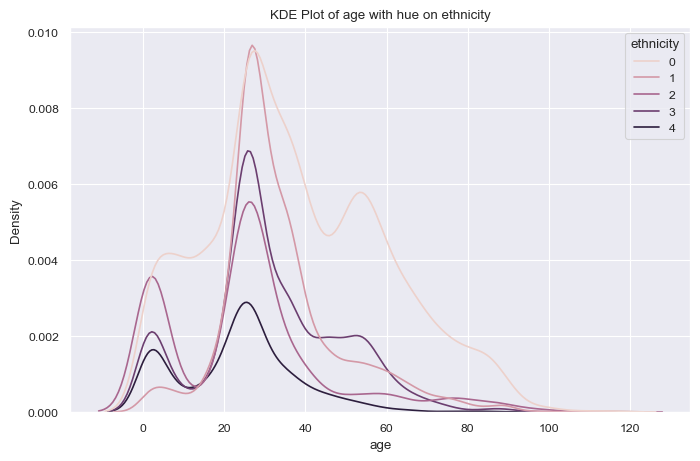

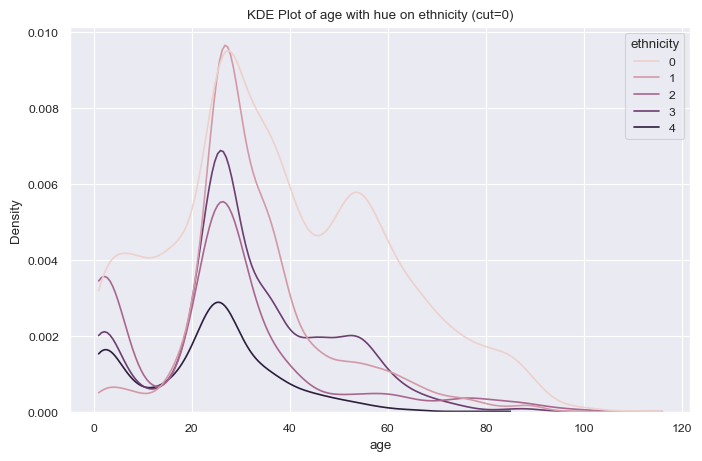

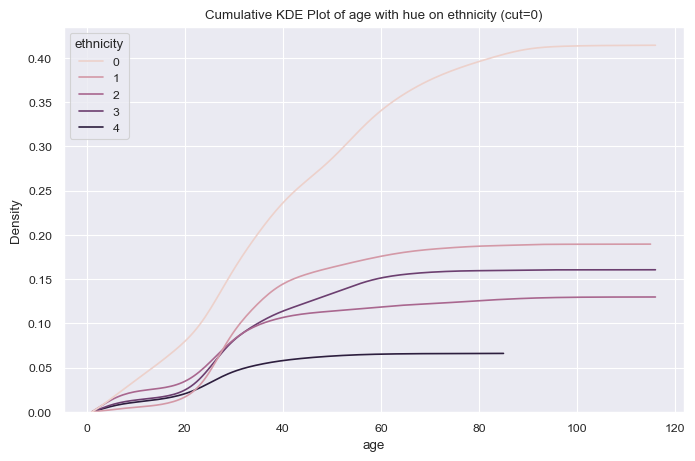

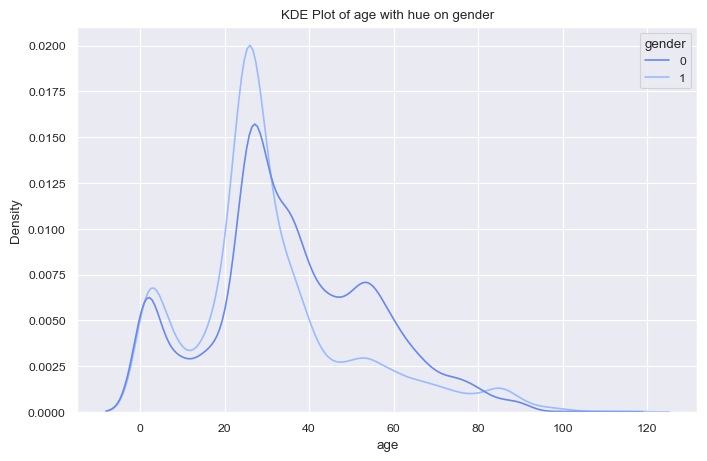

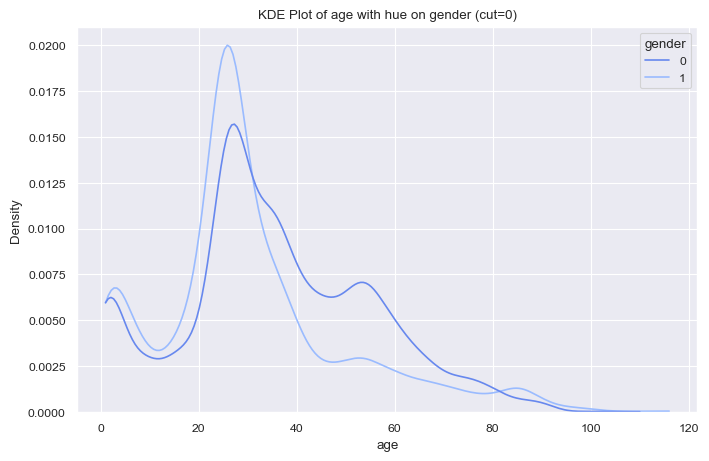

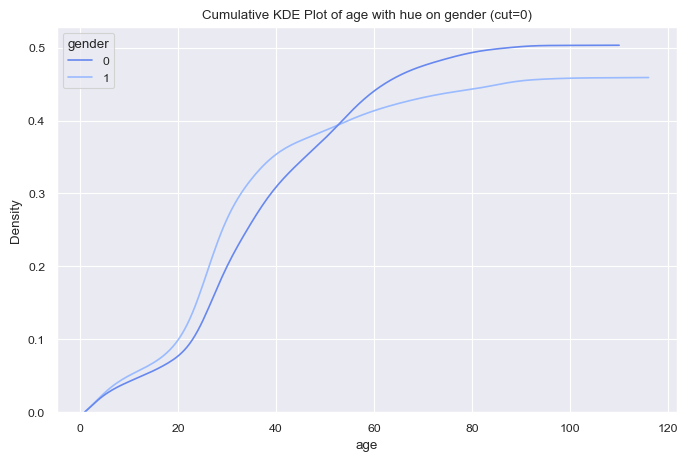

In [222]:
visualizer = DataVisualizer(age_gender_data, plot_width=8, plot_height=5)
#visualizer.visualize_all(num_vars=['age','ethnicity'], cat_vars=['ethnicity','gender'], hue=['ethnicity','gender'])
#visualizer.visualize_all(num_vars=['age','ethnicity'], cat_vars=['gender'], hue=['ethnicity','gender'])
visualizer.visualize_kdeplots(num_vars=['age'], hue=['ethnicity','gender'])

## 4- We print some pictures from our dataset to understand its content.

#### 4.0. We first apply the necessary transformations to convert the 'pixels' variable (with object type) to an array and later to a tensor

```python
return tf.reshape(np.array(pixels.split(), dtype="float32"), (48, 48,1))
```

This line of code is taking a string of pixel values, splitting it into a list, converting that list into a numpy array of type float32, and then reshaping that array into a 3D tensor with a shape of (48, 48,1)

In [223]:
# Define a function to convert pixel strings to tensors
def convert_pixels_to_tensor(pixels):
    return tf.reshape(np.array(pixels.split(), dtype="float32"), (48, 48,1))

# Copy the DataFrame and apply the conversion function
age_gender_data_tensor = age_gender_data.copy()
age_gender_data_tensor['pixels'] = age_gender_data['pixels'].apply(convert_pixels_to_tensor)

In [224]:
# Print the type of the entire 'pixels' column
print(f'{Back.RED}age_gender_data_tensor["pixels"] type:{Back.RESET}',
      f"\n{Back.BLUE}{type(age_gender_data_tensor['pixels'])}{Back.RESET}")

# Print the type of the first item in the 'pixels' column
print(f'{Back.RED}Type of the first item in age_gender_data_tensor["pixels"]:{Back.RESET}',
      f"\n{Back.BLUE}{type(age_gender_data_tensor['pixels'].iloc[0])}{Back.RESET}")


age_gender_data_tensor["pixels"] type: 
<class 'pandas.core.series.Series'>
Type of the first item in age_gender_data_tensor["pixels"]: 
<class 'tensorflow.python.framework.ops.EagerTensor'>


In [225]:
print(f'{Back.RED}First item in age_gender_data["pixels"]:{Back.RESET}',
      f"\n{Back.BLUE}{age_gender_data['pixels'].iloc[0]}{Back.RESET}")
print(f'{Back.RED}First item in age_gender_data_tensor["pixels"]:{Back.RESET}',
      f"\n{Back.BLUE}{age_gender_data_tensor['pixels'].iloc[0]}{Back.RESET}")

First item in age_gender_data["pixels"]: 
129 128 128 126 127 130 133 135 139 142 145 149 147 145 146 147 148 149 149 150 153 153 153 152 153 153 153 153 153 151 149 147 146 146 144 143 140 134 129 129 126 122 121 119 118 118 99 53 130 129 128 126 127 130 135 141 143 143 144 145 143 142 144 145 146 149 149 148 151 151 151 151 152 153 153 153 153 149 148 147 146 146 142 141 138 133 130 130 128 123 124 122 120 117 98 52 131 129 130 129 129 134 138 144 145 143 143 139 140 138 139 140 142 145 147 149 151 149 149 149 151 152 151 150 150 148 147 145 144 142 140 137 136 135 134 131 128 126 126 123 122 114 97 50 135 134 133 132 131 136 142 145 147 144 141 143 138 131 133 134 137 139 143 147 148 149 149 149 151 151 149 147 147 146 141 139 135 137 137 137 137 138 137 134 132 129 130 124 124 115 95 52 138 139 139 135 134 138 140 140 140 140 140 140 139 134 131 127 131 131 133 138 143 148 149 149 150 151 148 144 141 138 139 133 133 137 139 139 141 140 140 136 132 131 132 125 125 115 91 50 141 145 

#### 4.1. display_filtered_images(age_gender_data, age=1, ethnicity=0, gender=0, num_images=8)

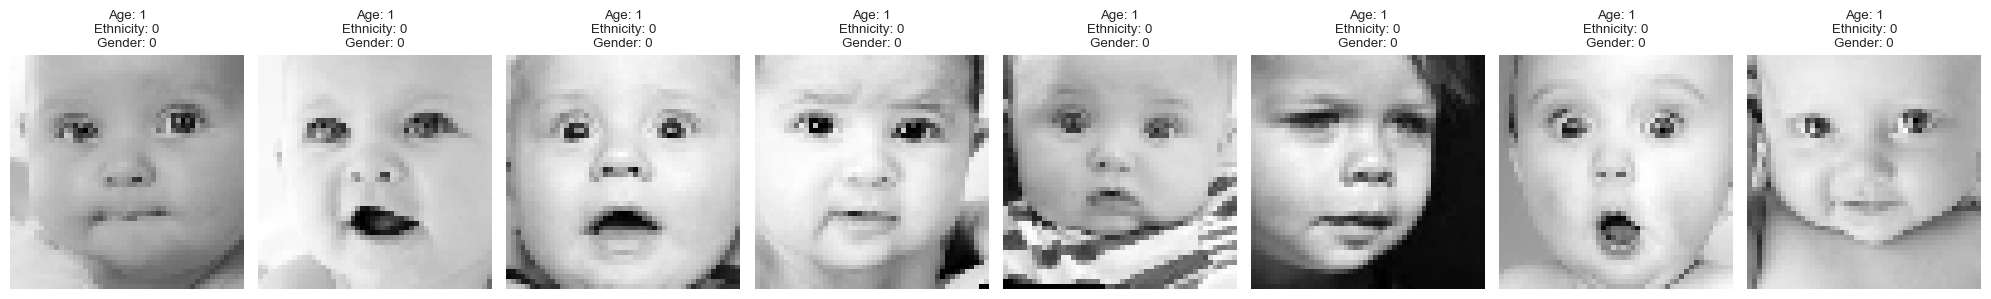

In [226]:
display_filtered_images(age_gender_data_tensor, age=1, ethnicity=0, gender=0, num_images=8)

#### 4.2. display_filtered_images(age_gender_data, age=10, ethnicity=1, gender=1, num_images=8)

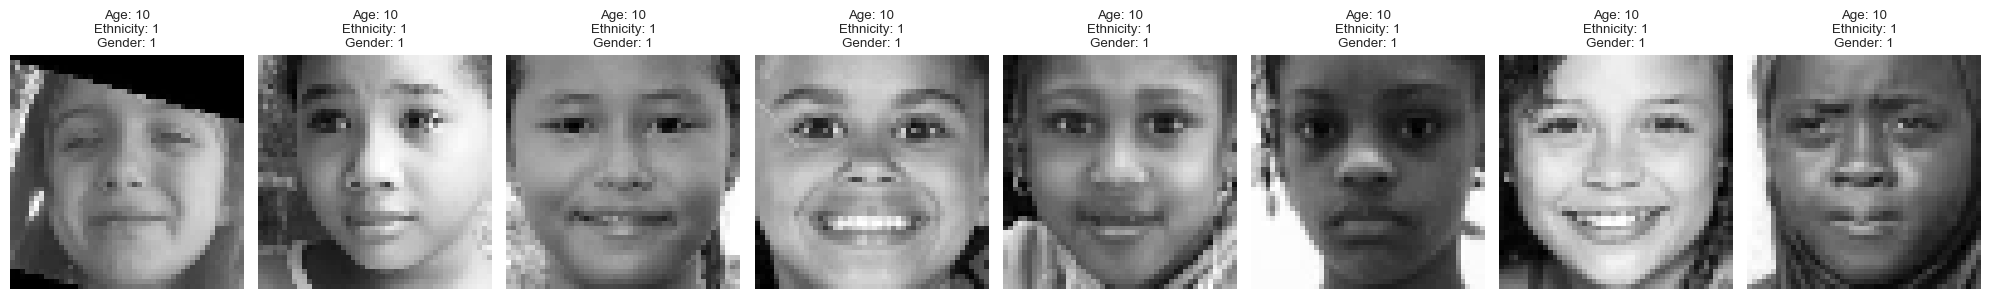

In [227]:
display_filtered_images(age_gender_data_tensor, age=10, ethnicity=1, gender=1, num_images=8)

#### 4.3. display_filtered_images(age_gender_data, age=20, ethnicity=2, gender=0, num_images=8)

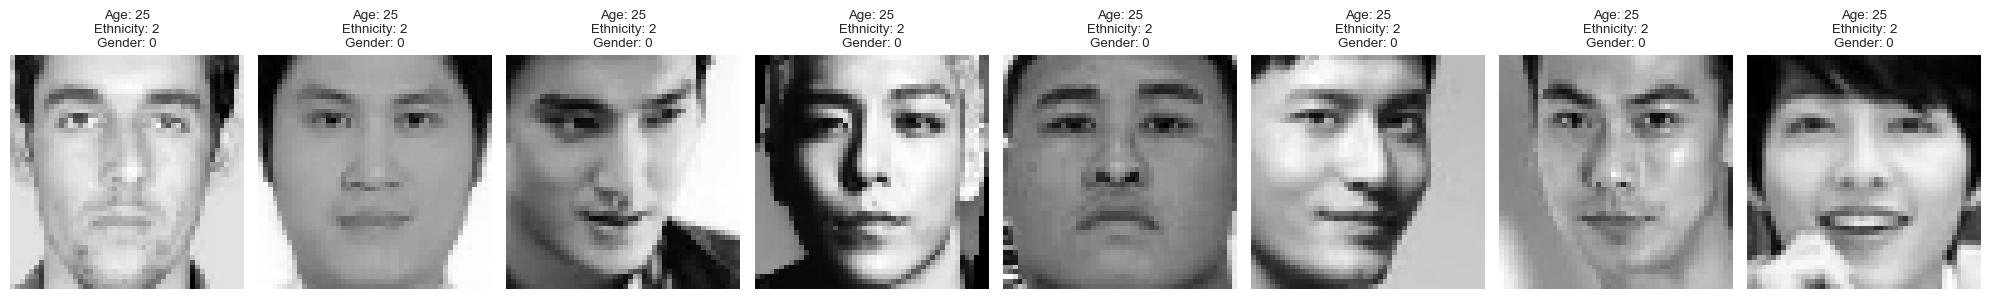

In [228]:
display_filtered_images(age_gender_data_tensor, age=25, ethnicity=2, gender=0, num_images=8)

#### 4.4. display_filtered_images(age_gender_data, age=35, ethnicity=3, gender=1, num_images=8)

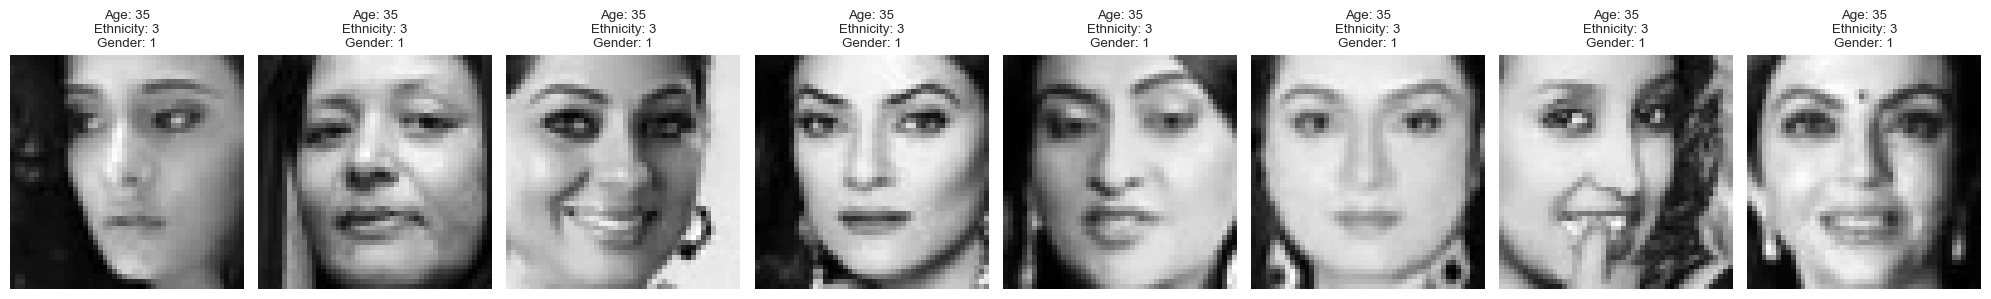

In [229]:
display_filtered_images(age_gender_data_tensor, age=35, ethnicity=3, gender=1, num_images=8)

#### 4.5. display_filtered_images(age_gender_data, age=45, ethnicity=4, gender=0, num_images=8)

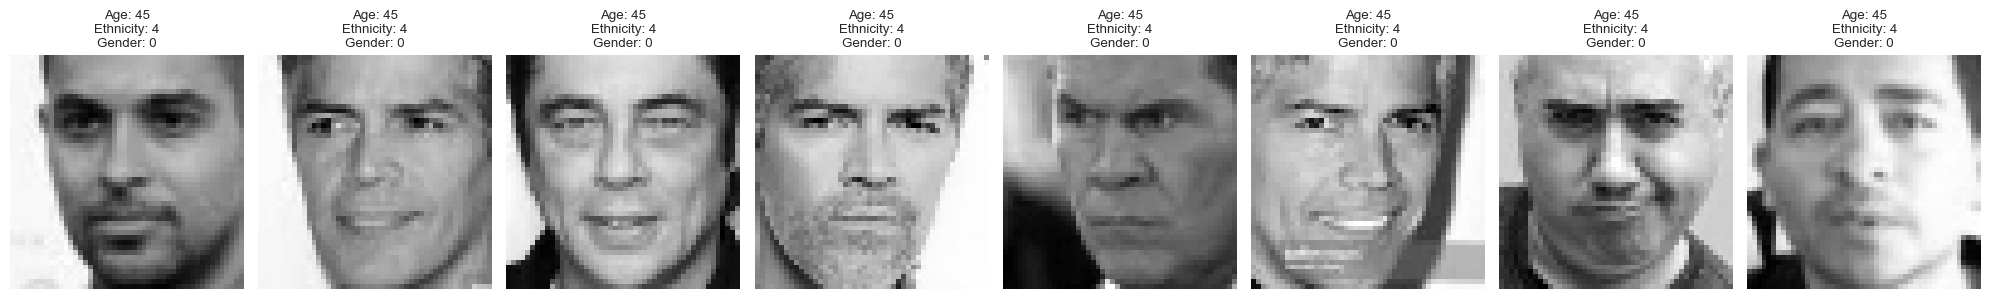

In [230]:
display_filtered_images(age_gender_data_tensor, age=45, ethnicity=4, gender=0, num_images=8)

#### 4.6. display_filtered_images(age_gender_data, age=55, ethnicity=0, gender=1, num_images=8)

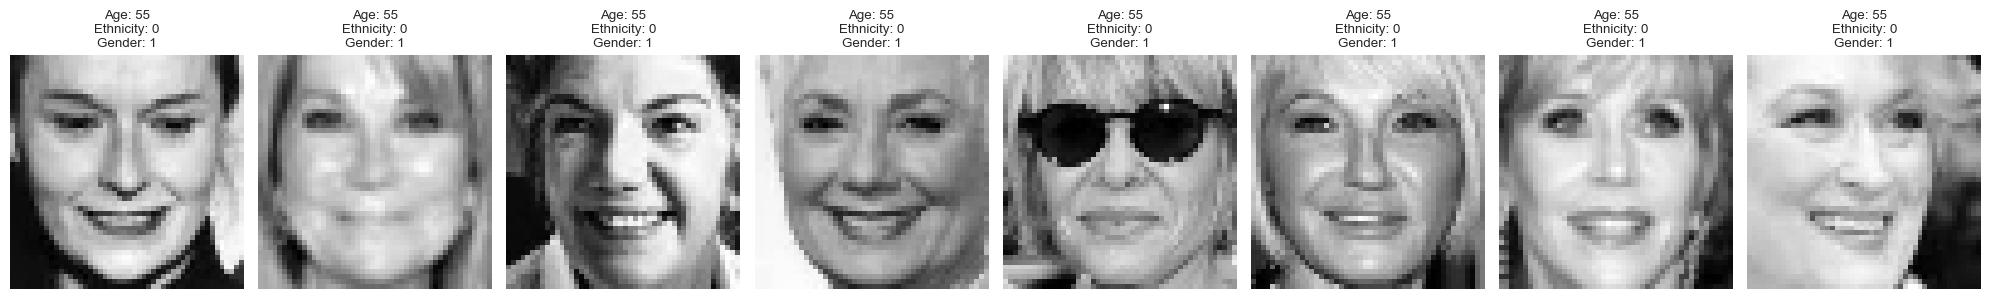

In [231]:
display_filtered_images(age_gender_data_tensor, age=55, ethnicity=0, gender=1, num_images=8)

#### 4.7. display_filtered_images(age_gender_data, age=65, ethnicity=1, gender=0, num_images=8)

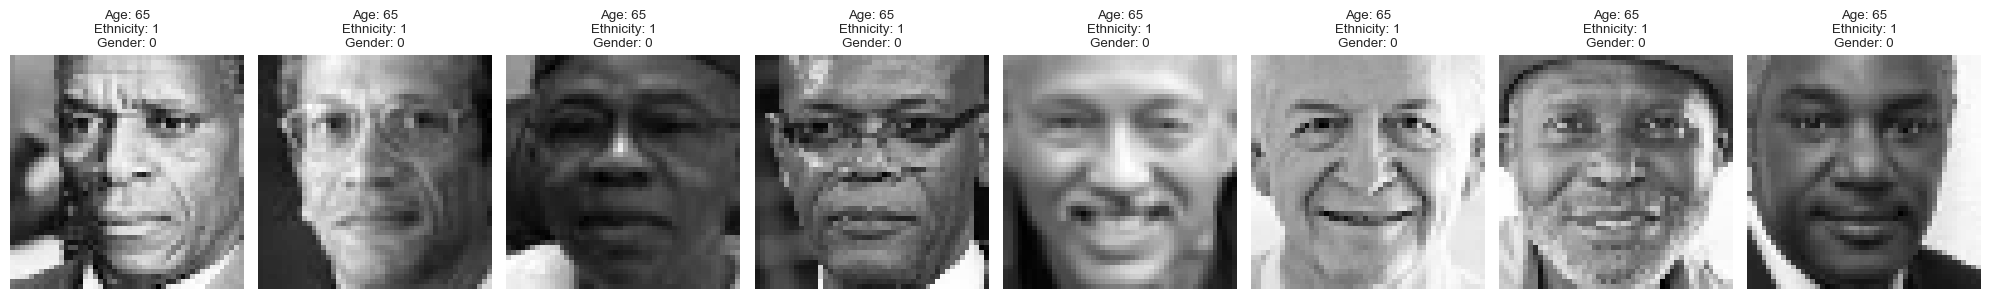

In [232]:
display_filtered_images(age_gender_data_tensor, age=65, ethnicity=1, gender=0, num_images=8)

#### 4.8. display_filtered_images(age_gender_data, age=40, ethnicity=2, gender=1, num_images=8)

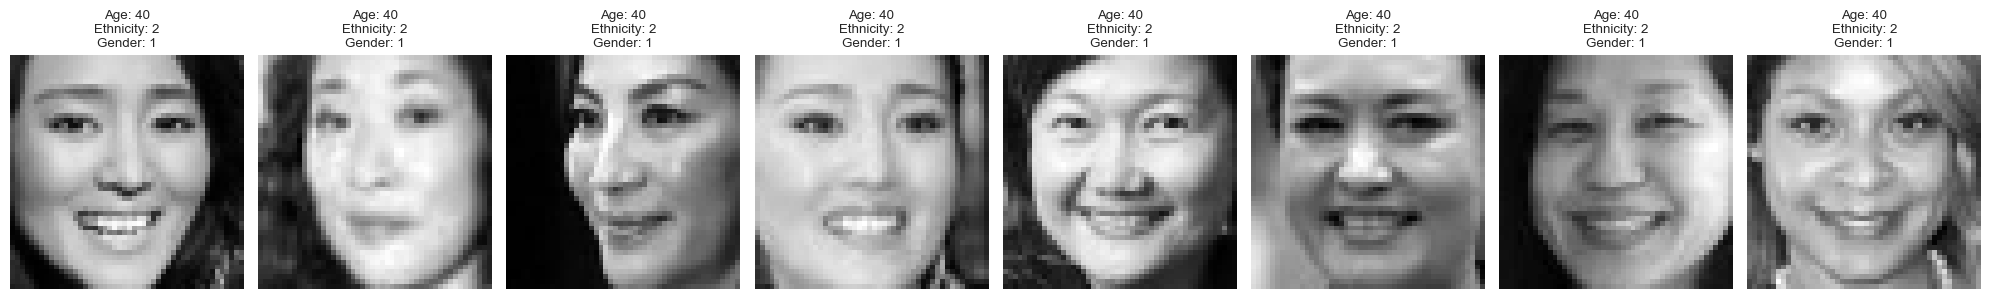

In [233]:
display_filtered_images(age_gender_data_tensor, age=40, ethnicity=2, gender=1, num_images=8)

#### 4.9. display_filtered_images(age_gender_data, age=5, ethnicity=4, gender=1, num_images=8)

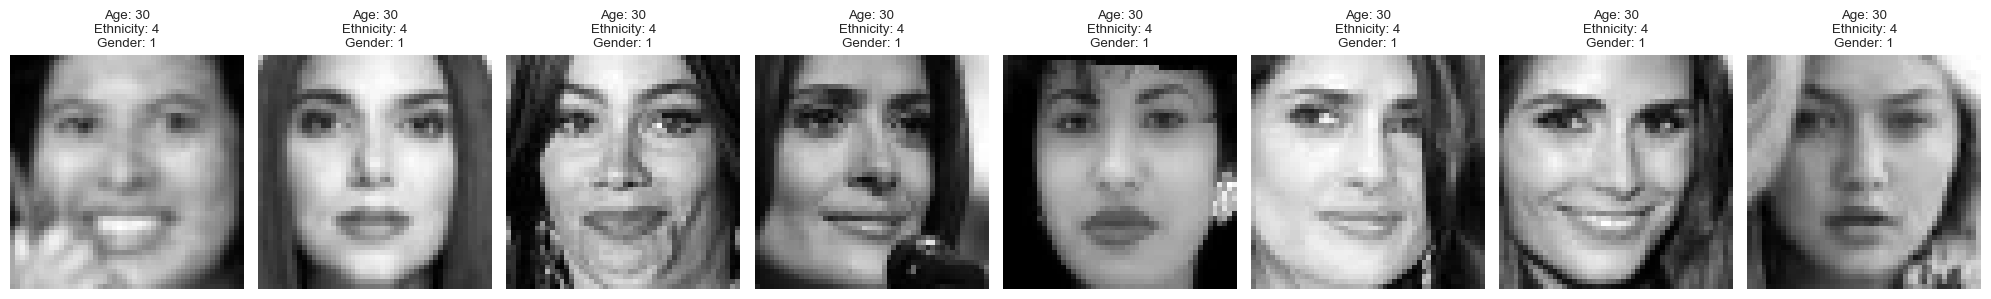

In [234]:
display_filtered_images(age_gender_data_tensor, age=30, ethnicity=4, gender=1, num_images=8)

## 5. Preparing the data for later usage in a neural network

We have a class to carry out the data preprocessing for our neural network. It has the following built-in functions:

1. init

- 1.1. The function returns the training and validation indices. These indices can then be used to create training and validation datasets from the original DataFrame. The advantage of this approach is that it allows for stratified sampling, ensuring that the training and validation sets have the same class distribution as the original dataset.

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

2. calculate_stats

- 2.1. This Python code defines a method calculate_stats that calculates the mean and standard deviation of pixel values from a list of pixel strings. It converts each pixel string into a tensor, normalizes the tensor by dividing by 255, and then updates the sum of pixel values, sum of squared pixel values, and total number of pixels. After processing all pixel strings, it calculates and returns the mean and standard deviation.

3. create_dataset

- 3.1. `tf.data.Dataset.from_tensor_slices` function is a convenient way to create a Dataset from data in memory. It creates a dataset where each element is a slice of the input tensors.

https://www.tensorflow.org/api_docs/python/tf/data/Dataset
https://www.tensorflow.org/api_docs/python/tf/numpy_function

- 3.2. `map` function is used to apply a function to each element in the dataset

https://docs.python.org/3/library/functions.html#map

- 3.3. `tf.numpy_function` is a TensorFlow operation that wraps a Python function. the Python function being wrapped is `self.preprocess`, and it's being passed two input tensors: `x` and `y`. `x` and `y` are the pixel data and label for an image, respectively. The dtype of the output tensors are specified as ``tf.float32` and `tf.int64`, which means the preprocess function is expected to return a tuple containing a float32 tensor and an int64 tensor.

- 3.4. The `num_parallel_calls` argument in the map function is set to `tf.data.experimental.AUTOTUNE`, which means that TensorFlow will choose the number of parallel calls to use based on available CPU.

https://www.tensorflow.org/api_docs/python/tf/data/experimental

4. preprocess

- 4.1. The `np.fromstring` function is used to convert a string of pixel values into a numpy array. The `pixel_string.decode('utf-8')` part of the code is decoding a byte string of pixel values into a regular string. The `sep=' '` argument specifies that the pixel values in the string are separated by spaces. The `dtype=np.float32` argument specifies that the data type of the numpy array should be float32.

https://numpy.org/doc/stable/reference/generated/numpy.fromstring.html
https://numpy.org/doc/stable/reference/arrays.scalars.html#numpy.float16
https://numpy.org/doc/stable/reference/generated/numpy.reshape.html#numpy-reshape


In [235]:
class DataProcessor:
    def __init__(self, dataframe, label_column, test_size=0.3, random_state=42):
        """
        Initialize the DataProcessor class with a dataframe, the name of the label column,
        split it into training and validation indices, and calculate the mean and standard
        deviation for normalization.

        Args:
            dataframe (pd.DataFrame): The full DataFrame.
            label_column (str): The name of the column to be used as the label.
            test_size (float): The proportion of the dataset to include in the test split.
            random_state (int): The seed used by the random number generator.
        """
        self.dataframe = dataframe
        self.label_column = label_column
        self.indices = np.arange(len(dataframe))
        self.train_indices, self.val_indices, _, _ = train_test_split(
            self.indices, dataframe[label_column].values, test_size=test_size, random_state=random_state)
        
        self.mean, self.std = self.calculate_stats(dataframe['pixels'])

    def calculate_stats(self, pixels_column):
        """Calculate the mean and standard deviation of a column of pixels.
        Args:
            pixels_column (list): A list of strings representing pixel values.
        Returns:
            tuple: A tuple containing the mean and standard deviation of the pixel values.
        """
        sum_pixels = tf.constant(0.0)
        sum_squared_pixels = tf.constant(0.0)
        num_pixels = 0

        for pixel_string in pixels_column:
            tensor = tf.convert_to_tensor([float(pix) for pix in pixel_string.split()], dtype=tf.float32)
            normalized_tensor = tensor / 255.0
            sum_pixels += tf.reduce_sum(normalized_tensor)
            sum_squared_pixels += tf.reduce_sum(tf.square(normalized_tensor))
            num_pixels += tf.size(normalized_tensor).numpy()

        mean = sum_pixels / num_pixels
        std = tf.sqrt((sum_squared_pixels / num_pixels) - tf.square(mean))
        return mean.numpy(), std.numpy()

    def create_dataset(self, dataframe, batch_size=32, shuffle=True):
        """
        Create a TensorFlow dataset from a pandas dataframe.

        Args:
            dataframe (pd.DataFrame): DataFrame containing the data.
            batch_size (int): Batch size.
            shuffle (bool): Whether to shuffle the data.

        Returns:
            tf.data.Dataset: A TensorFlow dataset.
        """
        def preprocess(pixel_string, label):
            """
            Preprocess the pixel string and label.

            Args:
                pixel_string (str): The pixel string.
                label: The label.

            Returns:
                tuple: A tuple containing the preprocessed pixels and label.
            """
            def _preprocess(pixel_string, label):
                """
                Preprocess the pixel string and label.

                Args:
                    pixel_string (str): The pixel string.
                    label: The label.

                Returns:
                    tuple: A tuple containing the preprocessed pixels and label.
                """
                pixels = np.fromstring(pixel_string.decode('utf-8'), sep=' ', dtype=np.float32)
                pixels = pixels.reshape(48, 48, 1)
                pixels = (pixels - self.mean) / self.std
                return pixels, label

            pixels, label = tf.numpy_function(_preprocess, [pixel_string, label], [tf.float32, tf.int64])
            pixels.set_shape((48, 48, 1))
            label.set_shape(())
            return pixels, label

        pixel_strings = dataframe['pixels'].values
        labels = dataframe[self.label_column].values  # Use the label column name passed to the class
        dataset = tf.data.Dataset.from_tensor_slices((pixel_strings, labels))
        dataset = dataset.map(preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)

        if shuffle:
            dataset = dataset.shuffle(buffer_size=len(dataframe))
        return dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

    def create_subset_dataset(self, indices, batch_size=32, shuffle=True):
        """
        Creates a subset dataset based on the given indices.

        Parameters:
        - indices (list): List of indices to select from the original dataset.
        - batch_size (int): Number of samples per batch. Default is 32.
        - shuffle (bool): Whether to shuffle the dataset. Default is True.

        Returns:
        - subset_dataset (Dataset): Subset dataset containing the selected samples.
        """
        subset_dataframe = self.dataframe.iloc[indices]
        return self.create_dataset(subset_dataframe, batch_size=batch_size, shuffle=shuffle)

#### 5.1. We instantiate the class and create the train and test datasets. We shuffle the training dataset but we don´t the testing dataset. We select the 'gender' as the target/label for the model.

In [236]:
# Initialize the DataProcessor instance
data_processor = DataProcessor(age_gender_data, 'gender')

# Create the training dataset using the DataProcessor instance
train_dataset_1= data_processor.create_subset_dataset(data_processor.train_indices, batch_size=32, shuffle=True)

# Create the validation dataset using the DataProcessor instance
val_dataset_1 = data_processor.create_subset_dataset(data_processor.val_indices, batch_size=32, shuffle=False)


#### 5.2. We inspect our training and validation datasets to understand their structure and element shapes of a Tensorflow `Dataset` object.

In [237]:
# Example function to inspect dataset structure and element shapes
def inspect_dataset(dataset):
    # Take one batch from the dataset
    for inputs, labels in dataset.take(1):
        # Print the shape of the inputs and labels
        print(f'{Back.RED}Input shape:{Back.RESET}', f"{Back.BLUE}{inputs.shape}{Back.RESET}")
        print(f'{Back.RED}Label shape:{Back.RESET}', f"{Back.BLUE}{labels.shape}{Back.RESET}")
        # Optionally, check the dtype
        print(f'{Back.RED}Input dtype:{Back.RESET}', f"{Back.BLUE}{inputs.dtype}{Back.RESET}")
        print(f'{Back.RED}Label dtype:{Back.RESET}', f"{Back.BLUE}{labels.dtype}{Back.RESET}")

# Assuming train_dataset and val_dataset are your datasets
print(f'{Back.RED}Training Dataset:{Back.RESET}')
inspect_dataset(train_dataset_1)
print(f'{Back.RED}Type:{Back.RESET}', f"{Back.BLUE}{type(train_dataset_1)}{Back.RESET}")
print(f'{Back.RED}Validation Dataset:{Back.RESET}')
inspect_dataset(val_dataset_1)
print(f'{Back.RED}Type:{Back.RESET}', f"{Back.BLUE}{type(val_dataset_1)}{Back.RESET}")

Training Dataset:


Input shape: (32, 48, 48, 1)
Label shape: (32,)
Input dtype: <dtype: 'float32'>
Label dtype: <dtype: 'int64'>
Type: <class 'tensorflow.python.data.ops.dataset_ops.PrefetchDataset'>
Validation Dataset:
Input shape: (32, 48, 48, 1)
Label shape: (32,)
Input dtype: <dtype: 'float32'>
Label dtype: <dtype: 'int64'>
Type: <class 'tensorflow.python.data.ops.dataset_ops.PrefetchDataset'>


#### 5.3. We plot some pictures to ensure we are going in the right direction.

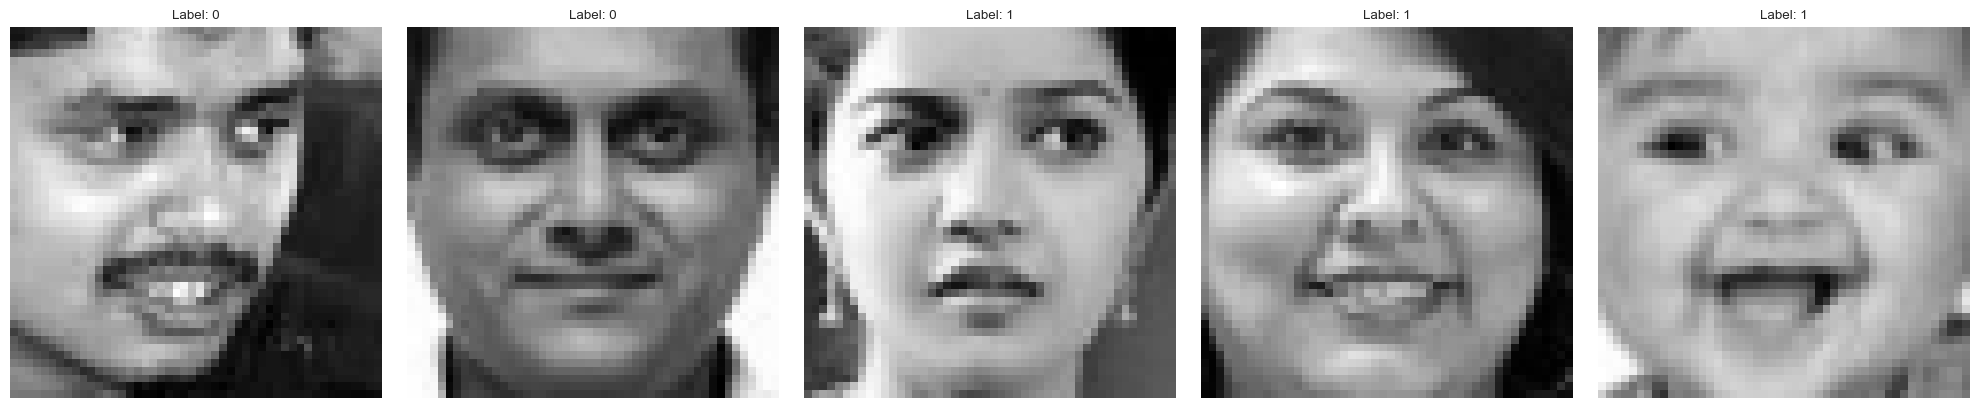

In [238]:
# Adjust 'num_images' to display the desired number of images
num_images = 5
fig, axes = plt.subplots(1, num_images, figsize=(20, 4))

for i, (images, labels) in enumerate(train_dataset_1.take(num_images)):
    img_array = images[0].numpy().squeeze()  # Select the first image in the batch and remove singleton dimensions
    ax = axes[i]
    ax.imshow(img_array, cmap='gray')  # Display the image in grayscale
    title = f"Label: {labels[0].numpy()}"  # Display the label for the first image
    ax.set_title(title)  # Set the title with label information
    ax.axis('off')  # Hide the axes

plt.tight_layout()
plt.show()


## 6. We train our first model: a single layer perceptron. Model 1


```python
model = models.Sequential
([
    layers.Flatten(input_shape=(48, 48, 1)),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])
```

https://keras.io/guides/sequential_model/

The `models.Sequential` function is a constructor for a Sequential model. The Sequential model is a linear stack of layers, where you can just add one layer at a time in a sequential manner.

https://keras.io/api/layers/reshaping_layers/flatten/

The `Flatten` layer is used to flatten the input. It does this by converting a multi-dimensional tensor into a one-dimensional tensor (also known as a vector).

https://keras.io/api/layers/core_layers/dense/

The `Dense` layer performs a dot product between the input and a set of learned weights, and then adds a bias term to the result. It's called a `Dense` layer because every neuron in a `Dense` layer is connected to every neuron in the previous layer. The `Dense` layer takes two arguments:
- The first argument, 64, is the number of neurons (also known as nodes) in the layer. The number of neurons is a hyperparameter.
- The second argument, `activation='relu'`, specifies the activation function to use after performing the dot product and adding the bias.

https://keras.io/api/layers/activations/

The sigmoid function is often used in the output layer of a binary classification model because it squashes its input into the range [0, 1], which can be interpreted as a probability.



#### 6.1. We define the architecture of the first model. Model 1

In [239]:
# Simplified model
model = models.Sequential([
    # Flatten the input layer
    layers.Flatten(input_shape=(48, 48, 1)),  # Assuming grayscale images
    # Single fully connected layer
    layers.Dense(64, activation='relu'),
    # Output layer with 1 unit for binary classification, using sigmoid for binary classification
    layers.Dense(1, activation='sigmoid')
])

https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam

The optimizer is responsible for updating the weights of the network in response to the error it makes on the training data. The goal of the optimizer is to minimize this error, and the way it does this is by adjusting the weights in the direction that makes the error smaller. This process is known as gradient descent.

The `tf.keras.optimizers.Adam` function is used to create an instance of the Adam optimizer. Adam is a popular choice of optimizer because it combines the advantages of two other extensions of stochastic gradient descent: AdaGrad and RMSProp.

In [240]:
# Using Adam as a more adaptive optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

https://keras.io/api/losses/probabilistic_losses/#binary_crossentropy-function

The loss function is a measure of how well the model's predictions match the true values. During training, the goal of the optimizer is to minimize the value of the loss function.

The `tf.keras.losses.BinaryCrossentropy` function is used to create an instance of the Binary Cross-Entropy loss. Binary Cross-Entropy loss is used in binary classification tasks, where each input can belong to one of two classes. It measures the "distance" between the model's predictions and the true values.

In [241]:
loss_function = tf.keras.losses.BinaryCrossentropy()

https://keras.io/api/metrics/classification_metrics/#f1score-class

The `tf.keras.metrics.BinaryAccuracy` function is used to create an instance of the Binary Accuracy metric.

The threshold parameter is set to 0.5. This means that the model's predicted probabilities that the inputs belong to the positive class will be rounded to the nearest integer to obtain the predicted classes. If the predicted probability is greater than or equal to 0.5, the predicted class is 1 (the positive class); otherwise, the predicted class is 0 (the negative class).

In [242]:
metric = tf.keras.metrics.BinaryAccuracy(threshold=0.5)

https://keras.io/api/models/model_training_apis/

https://keras.io/api/losses/

https://keras.io/api/metrics/

The `model.compile` method is used to configure the learning process before training the model. It takes three main arguments: an optimizer, a loss function, and a list of metrics.

In [243]:
# Compile the model
model.compile(optimizer=optimizer,
              loss=loss_function,
              metrics=metric)

#### 6.2. We dig deeper into the model features. Model 1

In [244]:
# Summarize the model
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_6 (Flatten)         (None, 2304)              0         
                                                                 
 dense_16 (Dense)            (None, 64)                147520    
                                                                 
 dense_17 (Dense)            (None, 1)                 65        
                                                                 
Total params: 147,585
Trainable params: 147,585
Non-trainable params: 0
_________________________________________________________________


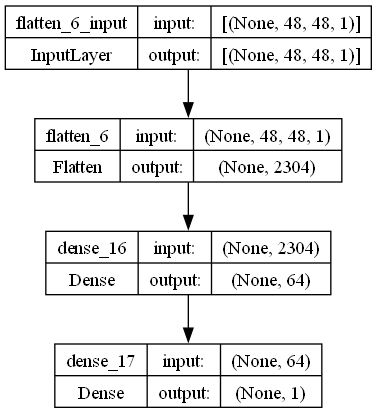

In [245]:
# Visualize the model
plot_model(model, show_shapes=True, show_layer_names=True, rankdir='TB')

#### 6.3. We train our model. Model 1

In [246]:
import keras
stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [247]:
class LearningRateLogger(keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
        self.learning_rates = []
        
    def on_epoch_end(self, epoch, logs=None):
        self.learning_rates.append(self.model.optimizer.lr.numpy())

# Include this callback during training
lr_logger = LearningRateLogger()


In [248]:
start_time = time.time()
history = model.fit(train_dataset_1,
                    epochs=1,
                    validation_data=val_dataset_1,
                    callbacks=[lr_logger, stop_early])
end_time = time.time()

519/519 [==============================] - 116s 69ms/step - loss: 66.4376 - binary_accuracy: 0.6977 - val_loss: 24.9223 - val_binary_accuracy: 0.7355


#### 6.4. Training time. Model 1

In [249]:
# Calculate and print the duration
duration_mins = (end_time - start_time)/60
print(f'{Back.RED}Training completed in (mins):{Back.RESET}',
    f"\n{Back.BLUE}{duration_mins:.3f}{Back.RESET}")

Training completed in (mins): 
1.931


#### 6.5. Model evaluation. Model 1

##### 1. Confusion Matrix

  1/223 [..............................] - ETA: 43s

223/223 [==============================] - 36s 161ms/step
              precision    recall  f1-score   support

     Class 0       0.94      0.53      0.68      3741
     Class 1       0.65      0.96      0.77      3371

    accuracy                           0.74      7112
   macro avg       0.79      0.75      0.73      7112
weighted avg       0.80      0.74      0.72      7112

Accuracy: 73.55%


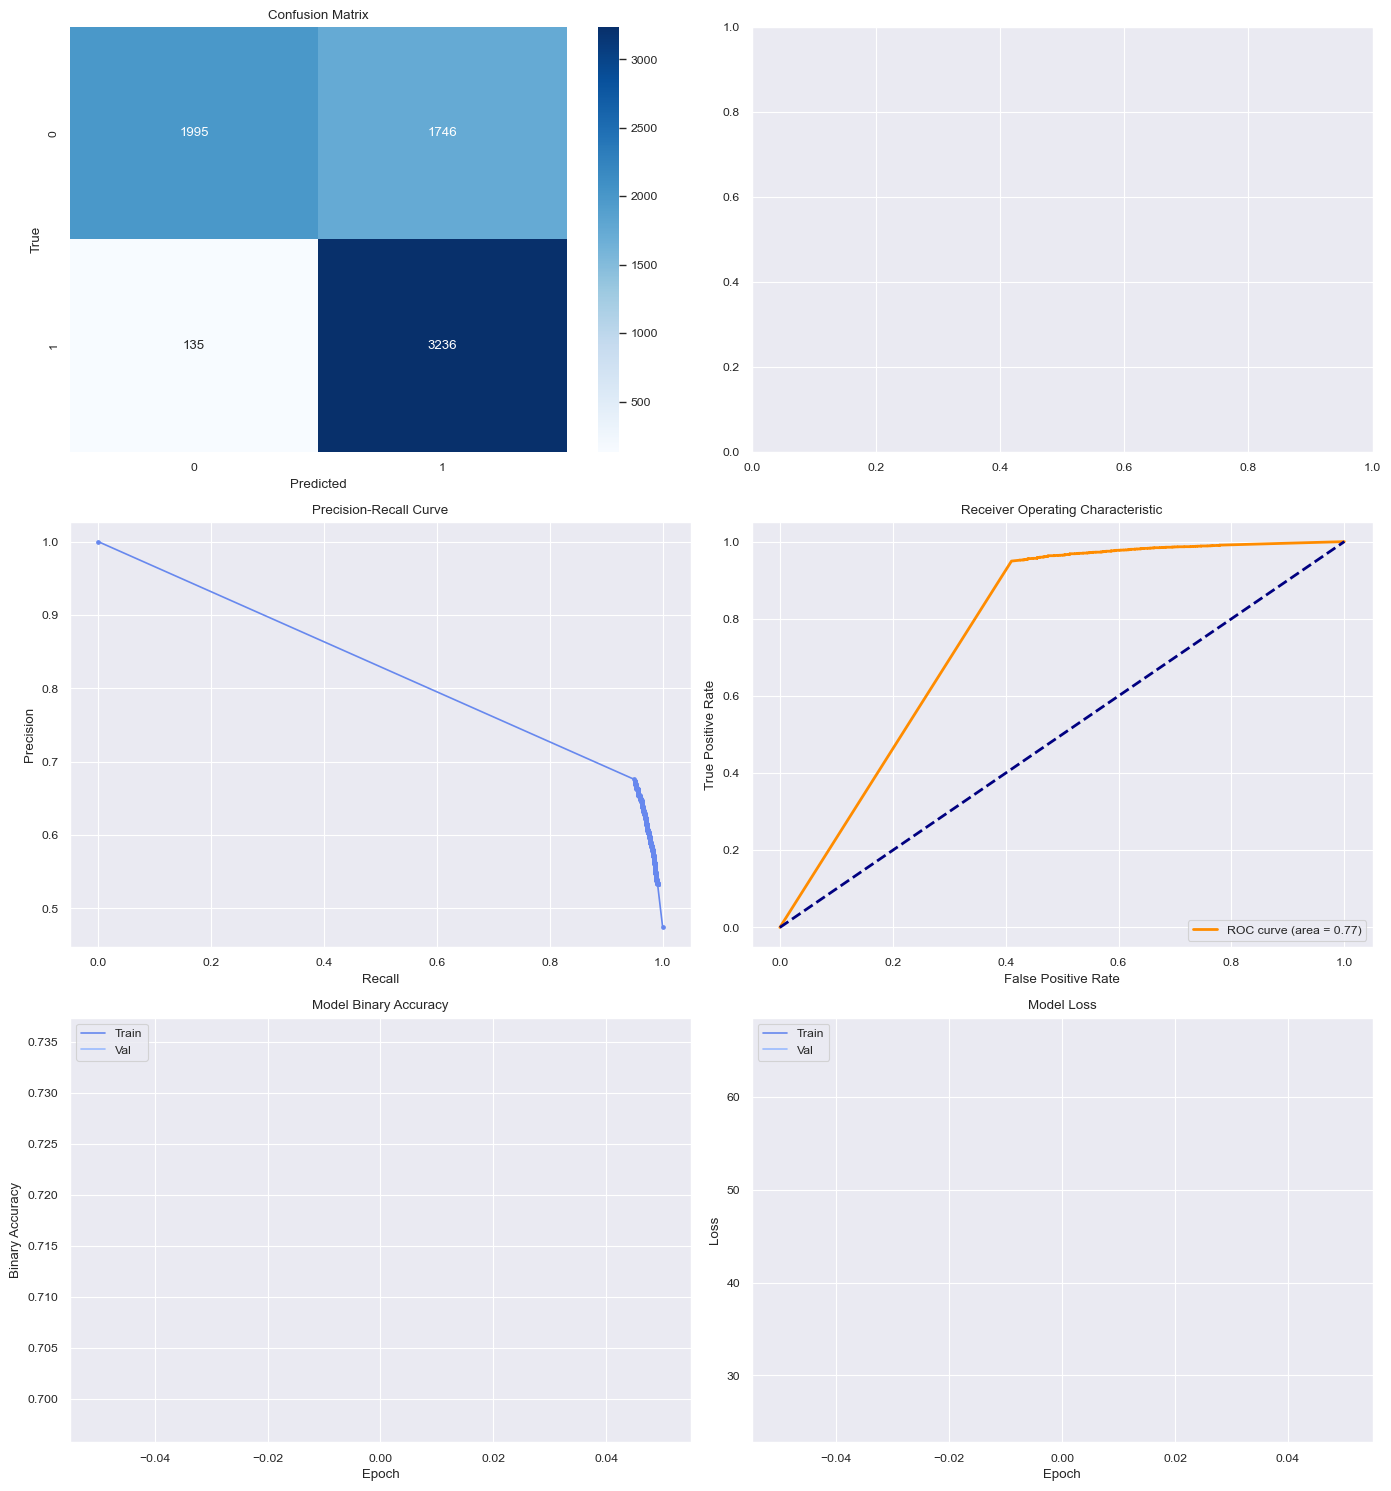

In [250]:
evaluate_neural_network(model, val_dataset_1, history)

  1/223 [..............................] - ETA: 36s

223/223 [==============================] - 36s 160ms/step


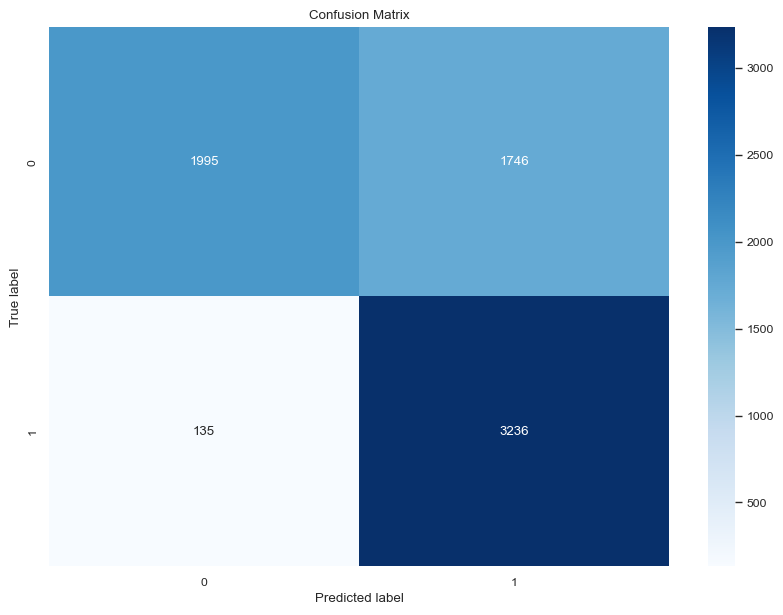

              precision    recall  f1-score   support

     Class 0       0.94      0.53      0.68      3741
     Class 1       0.65      0.96      0.77      3371

    accuracy                           0.74      7112
   macro avg       0.79      0.75      0.73      7112
weighted avg       0.80      0.74      0.72      7112

Accuracy: 73.55%


In [251]:

# Predict the labels for the validation set
y_pred_probs = model.predict(val_dataset_1)
y_pred = (y_pred_probs > 0.5).astype(int).reshape(-1)

#y_pred = (y_pred_probs > 0.5).astype(int)  # Threshold probabilities to get binary class labels

# Extract true labels from the validation dataset
y_true = np.concatenate([np.array([y.numpy()]) for x, y in val_dataset_1.unbatch()], axis=0)

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Print the classification report for all metrics
print(classification_report(y_true, y_pred, target_names=['Class 0', 'Class 1']))

# Calculate and print the accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")


#### 6.6. Visual inspection of missclassified pictures. Model 1

In [252]:
# Threshold probabilities to get binary class labels
#y_pred = (y_pred_probs > 0.5).astype(int).reshape(-1)
misclassified_indices = np.where(y_pred != y_true)[0]

In [253]:
def display_misclassified_images(dataset, misclassified_indices, num_images=10):
    """
    Display misclassified images from the dataset.

    Args:
        dataset (tf.data.Dataset): The dataset containing images and labels.
        misclassified_indices (np.array): Array containing indices of misclassified images.
        num_images (int): Number of misclassified images to display.
    """
    fig, axes = plt.subplots(1, num_images, figsize=(20, 4))
    i = 0  # Index for subplot
    count = 0  # Count to keep track of how many images we have displayed
    
    for idx, (image, label) in enumerate(dataset.unbatch()):
        if idx in misclassified_indices and count < num_images:
            img = image.numpy().squeeze()
            ax = axes[i]
            ax.imshow(img, cmap='gray')
            ax.set_title(f"True: {label.numpy()}, Pred: {y_pred[idx]}")
            ax.axis('off')
            i += 1
            count += 1
        
        if count >= num_images:
            break

    plt.tight_layout()
    plt.show()


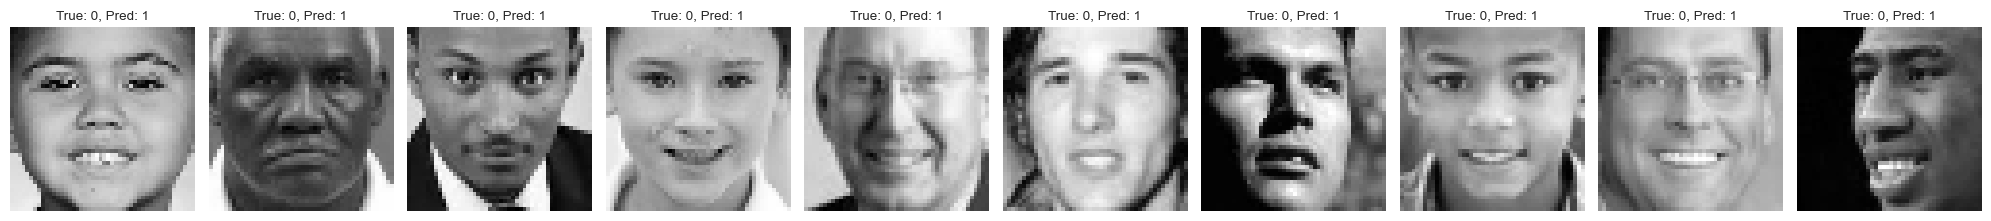

In [254]:
# Now call the function to display the misclassified images
display_misclassified_images(val_dataset_1, misclassified_indices)

In [255]:
# Example usage:
calculate_combined_misclassification_info(
    y_true, 
    y_pred, 
    age_gender_data, 
    category_names=['age', 'ethnicity', 'gender']
)


age - Misclassification rates:
  0-4: Total = 1605, Misclassified = 404 (25.17%)
  10-14: Total = 589, Misclassified = 167 (28.35%)
  100-104: Total = 14, Misclassified = 4 (28.57%)
  105-109: Total = 5, Misclassified = 0 (0.00%)
  110-114: Total = 6, Misclassified = 0 (0.00%)
  115-119: Total = 7, Misclassified = 4 (57.14%)
  15-19: Total = 942, Misclassified = 233 (24.73%)
  20-24: Total = 2310, Misclassified = 610 (26.41%)
  25-29: Total = 1634, Misclassified = 459 (28.09%)

age - Misclassification distribution:
  0-4: Misclassified = 404 (21.48%) of Total Misclassified = 1881
  10-14: Misclassified = 167 (8.88%) of Total Misclassified = 1881
  100-104: Misclassified = 4 (0.21%) of Total Misclassified = 1881
  105-109: Misclassified = 0 (0.00%) of Total Misclassified = 1881
  110-114: Misclassified = 0 (0.00%) of Total Misclassified = 1881
  115-119: Misclassified = 4 (0.21%) of Total Misclassified = 1881
  15-19: Misclassified = 233 (12.39%) of Total Misclassified = 1881
  20-24: 

#### 6.7. We train our model. Model 1.2.

We are changing our batch size from 32 to 64 instances

In [256]:
# Initialize the DataProcessor instance
data_processor = DataProcessor(age_gender_data, 'gender')

# Create the training dataset using the DataProcessor instance
train_dataset_2= data_processor.create_subset_dataset(data_processor.train_indices, batch_size=64, shuffle=True)

# Create the validation dataset using the DataProcessor instance
val_dataset_2 = data_processor.create_subset_dataset(data_processor.val_indices, batch_size=64, shuffle=False)

https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping

The selected code is creating an instance of the EarlyStopping callback from TensorFlow's Keras API. Callbacks in Keras are functions that can be applied at certain stages of the training process, such as at the end of each epoch. They are useful for logging, model checkpointing, learning rate changing, and much more.

In the provided code, the ``EarlyStopping`` callback is configured to monitor the ``val_loss`` metric. The val_loss is the value of the loss function for your cross-validation data, i.e., the error rate on data not used in training.

The ``min_delta`` parameter is the minimum change in the monitored quantity to qualify as an improvement. In this case, it's set to 0, meaning any improvement, no matter how small, counts as an improvement.

The ``patience`` parameter is the number of epochs with no improvement after which training will be stopped. Here, it's set to 5, meaning that the training process will stop if there has been no improvement in the val_loss for 5 consecutive epochs.

In [257]:
es_callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5)

https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint

The selected code is creating an instance of the ``ModelCheckpoint`` callback from TensorFlow's Keras API. Callbacks in Keras are functions that can be applied at certain stages of the training process, such as at the end of each epoch. They are useful for logging, model checkpointing, learning rate changing, and much more.

The ``save_best_only`` parameter, when set to True, means that the latest best model according to the quantity monitored will not be overwritten. If it's False, all models will be saved. Here, it's set to True, so only the best model (in terms of val_loss) will be saved.

In [258]:
modelckpt_callback = tf.keras.callbacks.ModelCheckpoint(monitor="val_loss",
                                                        filepath="model_checkpoint.h5",
                                                        verbose=1,
                                                        save_weights_only=True,
                                                        save_best_only=True)


In [259]:
start_time = time.time()
history_v2 = model.fit(train_dataset_2,
                    epochs=20,
                    validation_data=val_dataset_2,
                    callbacks=[es_callback, modelckpt_callback])
end_time = time.time()

Epoch 1/20


248/260 [===========================>..] - ETA: 0s - loss: 18.3777 - binary_accuracy: 0.7692
Epoch 1: val_loss improved from inf to 9.61944, saving model to model_checkpoint.h5
260/260 [==============================] - 115s 135ms/step - loss: 18.2536 - binary_accuracy: 0.7685 - val_loss: 9.6194 - val_binary_accuracy: 0.8174
Epoch 2/20
234/260 [==========================>...] - ETA: 0s - loss: 14.2922 - binary_accuracy: 0.7710
Epoch 2: val_loss improved from 9.61944 to 7.06476, saving model to model_checkpoint.h5
260/260 [==============================] - 116s 137ms/step - loss: 13.9167 - binary_accuracy: 0.7733 - val_loss: 7.0648 - val_binary_accuracy: 0.8223
Epoch 3/20
237/260 [==========================>...] - ETA: 0s - loss: 8.2684 - binary_accuracy: 0.7872
Epoch 3: val_loss did not improve from 7.06476
260/260 [==============================] - 115s 134ms/step - loss: 8.3966 - binary_accuracy: 0.7852 - val_loss: 9.8249 - val_binary_accuracy: 0.7645
Epoch 4/20
250/260 [============

#### 6.4. Training time. Model 1.2

In [ ]:
# Calculate and print the duration
duration_mins = (end_time - start_time)/60
print(f'{Back.RED}Training completed in (mins):{Back.RESET}',
    f"\n{Back.BLUE}{duration_mins:.3f}{Back.RESET}")

Training completed in (mins): 
69.487


#### 6.5. Model evaluation. Model 1.2

In [ ]:
evaluate_neural_network(model, val_dataset_2, history_v2)

112/112 [==============================] - 34s 306ms/step


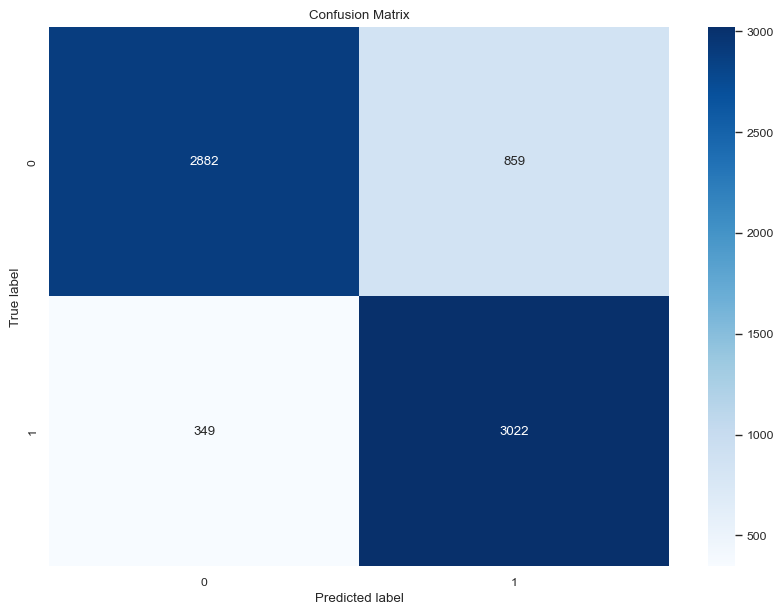

              precision    recall  f1-score   support

     Class 0       0.89      0.77      0.83      3741
     Class 1       0.78      0.90      0.83      3371

    accuracy                           0.83      7112
   macro avg       0.84      0.83      0.83      7112
weighted avg       0.84      0.83      0.83      7112

Accuracy: 83.01%


In [ ]:

# Predict the labels for the validation set
y_pred_probs = model.predict(val_dataset_2)
y_pred = (y_pred_probs > 0.5).astype(int).reshape(-1)

#y_pred = (y_pred_probs > 0.5).astype(int)  # Threshold probabilities to get binary class labels

# Extract true labels from the validation dataset
y_true = np.concatenate([np.array([y.numpy()]) for x, y in val_dataset_2.unbatch()], axis=0)

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Print the classification report for all metrics
print(classification_report(y_true, y_pred, target_names=['Class 0', 'Class 1']))

# Calculate and print the accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")


In [ ]:
# Example usage:
calculate_combined_misclassification_info(
    y_true, 
    y_pred, 
    age_gender_data, 
    category_names=['age', 'ethnicity', 'gender']
)


age - Misclassification rates:
  0-4: Total = 1605, Misclassified = 244 (15.20%)
  10-14: Total = 589, Misclassified = 106 (18.00%)
  100-104: Total = 14, Misclassified = 1 (7.14%)
  105-109: Total = 5, Misclassified = 0 (0.00%)
  110-114: Total = 6, Misclassified = 0 (0.00%)
  115-119: Total = 7, Misclassified = 3 (42.86%)
  15-19: Total = 942, Misclassified = 177 (18.79%)
  20-24: Total = 2310, Misclassified = 394 (17.06%)
  25-29: Total = 1634, Misclassified = 283 (17.32%)

age - Misclassification distribution:
  0-4: Misclassified = 244 (20.20%) of Total Misclassified = 1208
  10-14: Misclassified = 106 (8.77%) of Total Misclassified = 1208
  100-104: Misclassified = 1 (0.08%) of Total Misclassified = 1208
  105-109: Misclassified = 0 (0.00%) of Total Misclassified = 1208
  110-114: Misclassified = 0 (0.00%) of Total Misclassified = 1208
  115-119: Misclassified = 3 (0.25%) of Total Misclassified = 1208
  15-19: Misclassified = 177 (14.65%) of Total Misclassified = 1208
  20-24: M

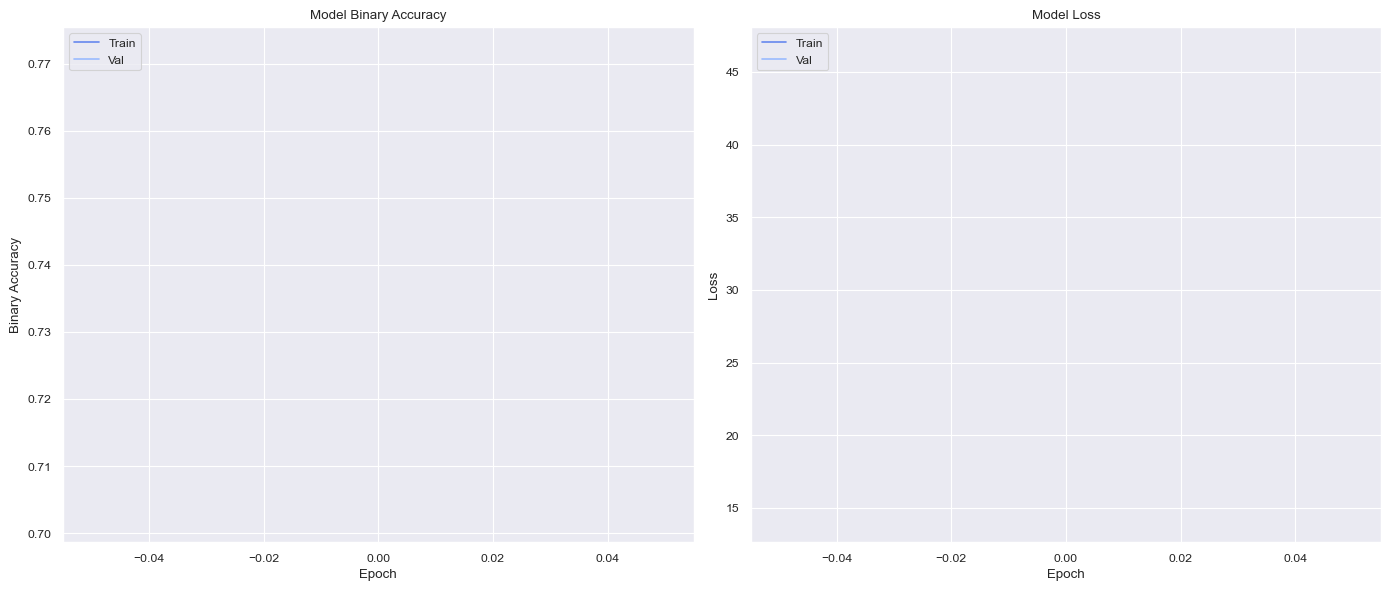

In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('Model Binary Accuracy')
plt.ylabel('Binary Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.tight_layout()
plt.show()

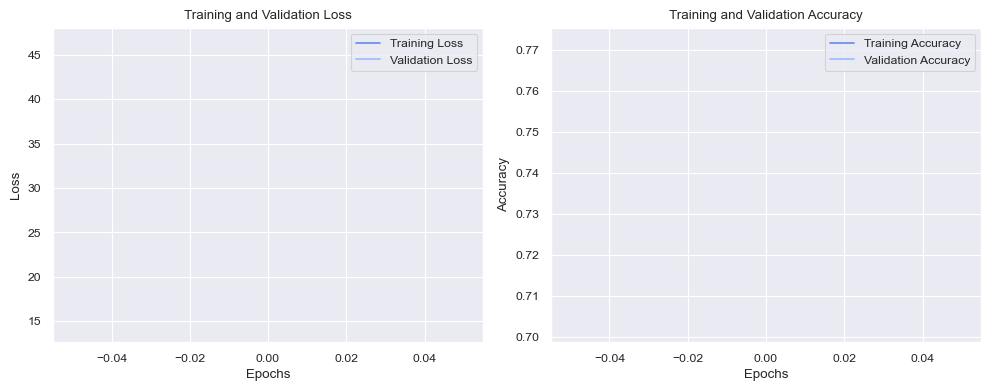

In [ ]:
# Plotting training and validation loss
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['binary_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_binary_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

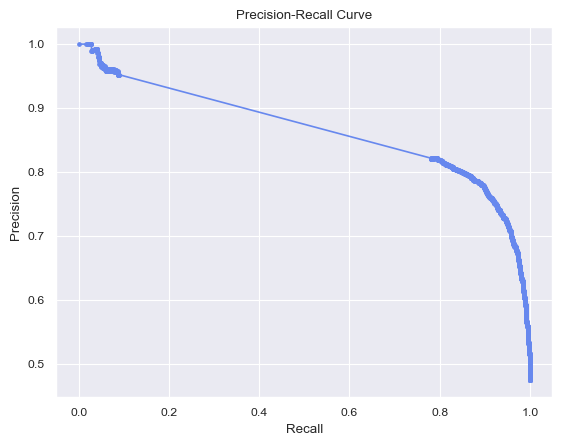

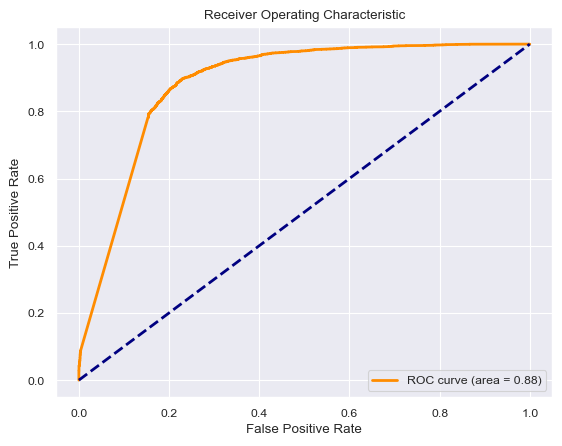

In [ ]:
from sklearn.metrics import precision_recall_curve, roc_curve, auc
import matplotlib.pyplot as plt

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_true, y_pred_probs)
plt.plot(recall, precision, marker='.')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


## 7. We train our second model by tuning the hyper-parameters. Model 2

#### 7.1 Model definition with hyper-parameters. Model 2

##### The hyper-parameters we suggest are:

1. Activation functions: 'relu', 'tanh', 'sigmoid','leaky_relu'

2. Number of units (aka neurons): min_value=32, max_value=512

3. Learning rate: min_value=1e-4, max_value=1e-2

The opmitiser is Adam.

The loss function Binary Cross Entropy.

The metrics are Binary Accuracy and AUC.

In [ ]:
import keras_tuner as kt
from tensorflow import keras

def build_model(hp):
    model = keras.Sequential()
    model.add(keras.layers.Flatten(input_shape=(48, 48, 1)))

    # Hyperparameter for the activation function of the first dense layer
    activation_choice = hp.Choice('activation', values=['relu', 'tanh', 'sigmoid','leaky_relu'])
    
    # Hyperparameter for the number of units in the first dense layer
    units_choice = hp.Int('units', min_value=32, max_value=512, step=32)

    model.add(keras.layers.Dense(units=units_choice, activation=activation_choice))
    model.add(keras.layers.Dense(1, activation='sigmoid'))

    # Hyperparameters for the optimizer
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss_function = keras.losses.BinaryCrossentropy()

    # You can define multiple metrics and Keras Tuner will consider the first one for optimization
    metrics = [keras.metrics.BinaryAccuracy(threshold=0.5),
               keras.metrics.AUC()]

    model.compile(optimizer=optimizer,
                  loss=loss_function,
                  metrics=metrics)
    
    return model


#### 7.2 We instantiate the keras tuner with BayesianOptimization tuning with Gaussian process. Model 2

https://keras.io/keras_tuner/

https://keras.io/api/keras_tuner/tuners/bayesian/

Bayesian Optimization is a type of model-based optimization algorithm that uses past evaluation results to form a probabilistic model mapping hyperparameters to a probability of a score on the objective function, which is then used to determine the next set of hyperparameters to evaluate.

- `build_model`: This is a function that returns a compiled model. The tuner will call this function with different combinations of hyperparameters to find the best model.

- ``objective='val_binary_accuracy'``: This is the metric that the tuner will optimize. In this case, it's the binary accuracy on the validation set.

- ``max_trials=10``: This is the maximum number of different hyperparameter combinations that the tuner will try.

- ``directory='keras_tuner_bayesian'``: This is the directory where the tuner will save its progress. This allows you to resume tuning later if needed.

- ``project_name='gender_classification'``: This is the name of the tuning project. It's used to organize different tuning runs in the directory.

- ``seed=42``: This is the random seed for reproducibility. It ensures that the tuner will produce the same results if run multiple times with the same inputs.

https://keras.io/api/callbacks/early_stopping/

The ``keras.callbacks.EarlyStopping`` function is used to create an instance of the EarlyStopping callback. This callback will stop the training process early if the model's performance on a validation metric stops improving for a certain number of epochs.

The ``patience`` parameter is used to specify the number of epochs with no improvement after which training will be stopped.

In [ ]:
# Bayesian optimization tuner
tuner = kt.BayesianOptimization(
    build_model,
    objective='val_binary_accuracy',  # Change this if you want to optimize a different metric
    max_trials=10,  # Number of variations on the hyperparameters
    directory='keras_tuner_bayesian',
    project_name='gender_classification',
    seed=42  # Random seed for reproducibility
)

# Early stopping callback
stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# Start the hyperparameter tuning process
tuner.search(train_dataset_1,
             epochs=2,
             validation_data=val_dataset_1,
             callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal activation function is {best_hps.get('activation')}.
The optimal learning rate for the optimizer is {best_hps.get('learning_rate')}.
""")

# Build the model with the optimal hyperparameters and train it on the data
model_2 = tuner.hypermodel.build(best_hps)
history_v3 = model.fit(train_dataset_1, epochs=2, validation_data=val_dataset_1)


Reloading Tuner from keras_tuner_bayesian\gender_classification\tuner0.json

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 64 and the optimal activation function is leaky_relu.
The optimal learning rate for the optimizer is 0.008547485565344062.

Epoch 1/2


519/519 [==============================] - 113s 65ms/step - loss: 0.4509 - binary_accuracy: 0.8046 - val_loss: 0.4147 - val_binary_accuracy: 0.8276
Epoch 2/2


KeyboardInterrupt: 

In [ ]:
# Summarize the model
model_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 2304)              0         
                                                                 
 dense (Dense)               (None, 64)                147520    
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 147,585
Trainable params: 147,585
Non-trainable params: 0
_________________________________________________________________


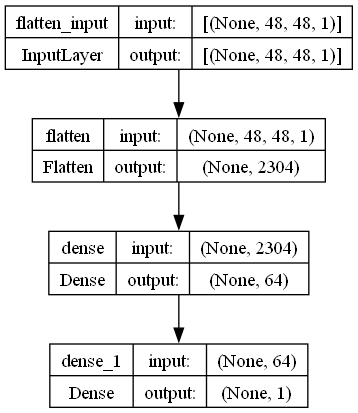

In [ ]:
# Visualize the model
plot_model(model_2, show_shapes=True, show_layer_names=True, rankdir='TB')

#### 7.3 We train our model with the best hyper-parameters identified previously. Model 2

1. The optimal number of units in the first densely-connected layer is 64 
2. The optimal activation function is leaky_relu.
3. The optimal learning rate for the optimizer is 0.008547485565344062.

In [ ]:
start_time = time.time()
history_v3 = model_2.fit(train_dataset_1, 
                         epochs=30, 
                         validation_data=val_dataset_1,
                         callbacks=[es_callback, modelckpt_callback])
end_time = time.time()

Epoch 1/30


507/519 [============================>.] - ETA: 0s - loss: 333.8549 - binary_accuracy: 0.6938 - auc: 0.6946
Epoch 1: val_loss did not improve from 0.36223
519/519 [==============================] - 119s 67ms/step - loss: 330.0939 - binary_accuracy: 0.6940 - auc: 0.6947 - val_loss: 368.6613 - val_binary_accuracy: 0.5665 - val_auc: 0.5434
Epoch 2/30
519/519 [==============================] - ETA: 0s - loss: 86.3618 - binary_accuracy: 0.7586 - auc: 0.7596
Epoch 2: val_loss did not improve from 0.36223
519/519 [==============================] - 111s 68ms/step - loss: 86.3618 - binary_accuracy: 0.7586 - auc: 0.7596 - val_loss: 94.9615 - val_binary_accuracy: 0.6437 - val_auc: 0.6652
Epoch 3/30
499/519 [===========================>..] - ETA: 0s - loss: 45.6087 - binary_accuracy: 0.7565 - auc: 0.7592
Epoch 3: val_loss did not improve from 0.36223
519/519 [==============================] - 118s 76ms/step - loss: 44.7940 - binary_accuracy: 0.7567 - auc: 0.7596 - val_loss: 32.1571 - val_binary_ac

#### Training time. Model 2

In [ ]:
# Calculate and print the duration
duration_mins = (end_time - start_time)/60
print(f'{Back.RED}Training completed in (mins):{Back.RESET}',
    f"\n{Back.BLUE}{duration_mins:.3f}{Back.RESET}")

Training completed in (mins): 
1.951


#### 7.4 We evaluate our model. Model 2

```python 
y_pred_probs = model.predict(val_dataset_1)
```

The ``model.predict`` method is used to make predictions on the ``val_dataset_1`` validation dataset. This method returns a probability for each input sample, which represents the model's confidence that the sample belongs to the positive class. These probabilities are stored in the ``y_pred_probs`` variable.


```python 
y_pred = (y_pred_probs > 0.5).astype(int).reshape(-1)
```

This is converting these probabilities into binary class labels. This is done by comparing the probabilities to a threshold of 0.5. If the probability is greater than 0.5, the predicted class label is 1 (the positive class); otherwise, the predicted class label is 0 (the negative class). 

The ``astype(int)`` method is used to convert the Boolean values (True and False) resulting from the comparison to integers (1 and 0). The ``reshape(-1)`` method is used to flatten the array of class labels into a 1D array.


In [ ]:
evaluate_neural_network(model_2, val_dataset_1, history_v3)

In [ ]:
# Predict the labels for the validation set
y_pred_probs = model_2.predict(val_dataset_1)
y_pred = (y_pred_probs > 0.5).astype(int).reshape(-1)
# Extract true labels from the validation dataset
y_true = np.concatenate([np.array([y.numpy()]) for x, y in val_dataset_1.unbatch()], axis=0)

223/223 [==============================] - 35s 156ms/step


#### 7.5 We plot the confusion matrix. Model 2

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html

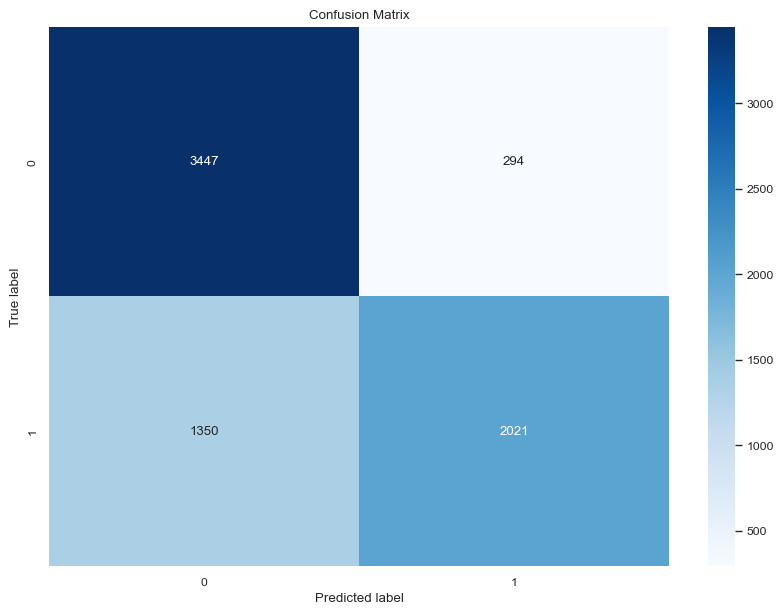

In [ ]:
# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)
# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

#### 7.6 We print the classification report and the accuracy score. Model 2

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html#sklearn-metrics-classification-report

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score

In [ ]:
# Print the classification report for all metrics
print(classification_report(y_true, y_pred, target_names=['Class 0', 'Class 1']))

# Calculate and print the accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

              precision    recall  f1-score   support

     Class 0       0.72      0.92      0.81      3741
     Class 1       0.87      0.60      0.71      3371

    accuracy                           0.77      7112
   macro avg       0.80      0.76      0.76      7112
weighted avg       0.79      0.77      0.76      7112

Accuracy: 76.88%


#### 7.7 We the misclassification information where the misclassified instances are broken down by the original labels. Model 2

1. gender - Misclassification rates (of the total instances how many have been misclassified broken down by gender):
  - 0: Total = 2648, Misclassified = 636 (24.02%)
  - 1: Total = 4464, Misclassified = 1057 (23.68%)

2. gender - Misclassification distribution (of the misclassified instance the distribution between the different values of gender):
  - 0: Misclassified = 636 (37.57%) of Total Misclassified = 1693
  - 1: Misclassified = 1057 (62.43%) of Total Misclassified = 1693

In [ ]:
# Example usage:
calculate_combined_misclassification_info(
    y_true, 
    y_pred, 
    age_gender_data, 
    category_names=['age', 'ethnicity', 'gender']
)


age - Misclassification rates:
  0-4: Total = 1605, Misclassified = 362 (22.55%)
  10-14: Total = 589, Misclassified = 130 (22.07%)
  100-104: Total = 14, Misclassified = 2 (14.29%)
  105-109: Total = 5, Misclassified = 1 (20.00%)
  110-114: Total = 6, Misclassified = 0 (0.00%)
  115-119: Total = 7, Misclassified = 5 (71.43%)
  15-19: Total = 942, Misclassified = 227 (24.10%)
  20-24: Total = 2310, Misclassified = 535 (23.16%)
  25-29: Total = 1634, Misclassified = 382 (23.38%)

age - Misclassification distribution:
  0-4: Misclassified = 362 (22.02%) of Total Misclassified = 1644
  10-14: Misclassified = 130 (7.91%) of Total Misclassified = 1644
  100-104: Misclassified = 2 (0.12%) of Total Misclassified = 1644
  105-109: Misclassified = 1 (0.06%) of Total Misclassified = 1644
  110-114: Misclassified = 0 (0.00%) of Total Misclassified = 1644
  115-119: Misclassified = 5 (0.30%) of Total Misclassified = 1644
  15-19: Misclassified = 227 (13.81%) of Total Misclassified = 1644
  20-24:

In [ ]:
# List all data in history
print(history.history.keys())

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


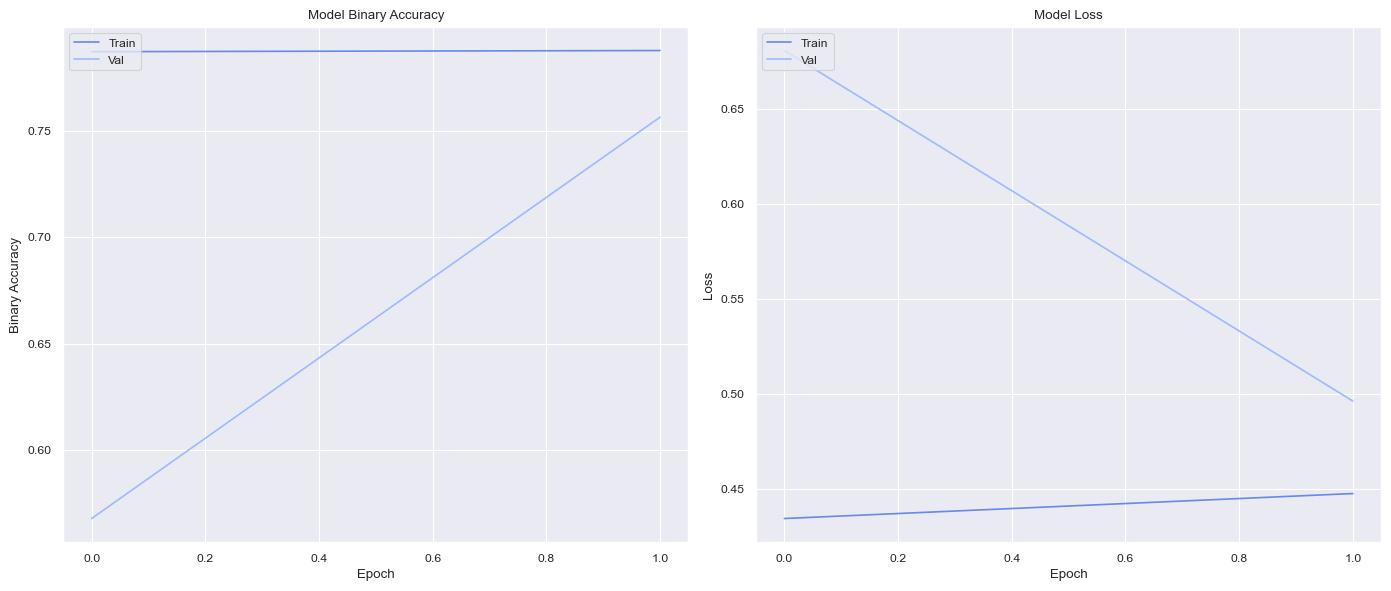

In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('Model Binary Accuracy')
plt.ylabel('Binary Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.tight_layout()
plt.show()

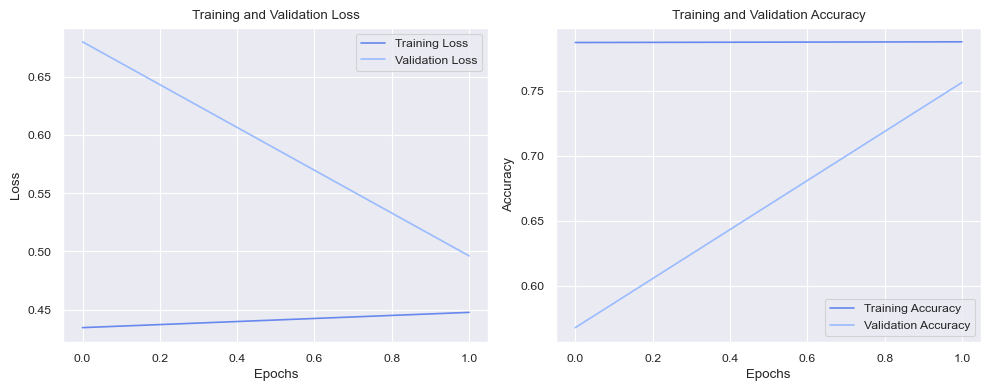

In [ ]:
# Plotting training and validation loss
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['binary_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_binary_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

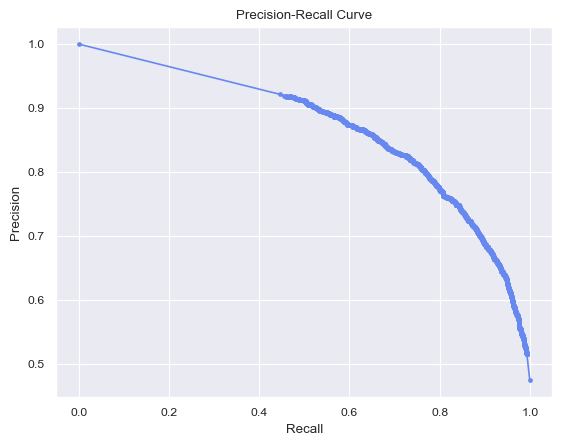

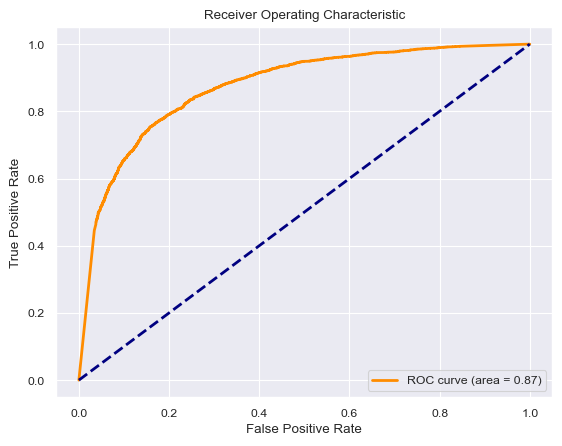

In [ ]:
from sklearn.metrics import precision_recall_curve, roc_curve, auc
import matplotlib.pyplot as plt

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_true, y_pred_probs)
plt.plot(recall, precision, marker='.')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


Gaussian Error Linear Unit (GELU), a high-performing neural network activation function. The GELU activation function is xΦ(x), where Φ(x) the standard Gaussian cumulative distribution function. The GELU nonlinearity weights inputs by their value, rather than gates inputs by their sign as in ReLUs (x1x>0). We perform an empirical evaluation of the GELU nonlinearity against the ReLU and ELU activations and find performance improvements across all considered computer vision, natural language processing, and speech tasks.

https://arxiv.org/abs/1606.08415

In [ ]:
import keras_tuner as kt
from tensorflow import keras


def build_model_v2(hp):
    model = keras.Sequential()
    model.add(keras.layers.Flatten(input_shape=(48, 48, 1)))

    # Hyperparameter for the activation function of the first dense layer
    activation_choice = hp.Choice('activation', values=['relu', 'gelu','leaky_relu'])
    
    # Hyperparameter for the number of units in the first dense layer
    units_choice = hp.Int('units', min_value=32, max_value=512, step=32)

    model.add(keras.layers.Dense(units=units_choice, activation=activation_choice))
    model.add(keras.layers.Dense(1, activation='sigmoid'))

    # Hyperparameters for the optimizer
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss_function = keras.losses.BinaryCrossentropy()

    # You can define multiple metrics and Keras Tuner will consider the first one for optimization
    metrics = [keras.metrics.BinaryAccuracy(threshold=0.5),
               keras.metrics.AUC()]

    model.compile(optimizer=optimizer,
                  loss=loss_function,
                  metrics=metrics)
    
    return model


In [ ]:
# Bayesian optimization tuner
tuner_2 = kt.BayesianOptimization(
    build_model_v2,
    objective='val_binary_accuracy',  # Change this if you want to optimize a different metric
    max_trials=5,  # Number of variations on the hyperparameters
    directory='keras_tuner_bayesian',
    project_name='gender_classification_v2',
    seed=42  # Random seed for reproducibility
)

# Early stopping callback
stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# Start the hyperparameter tuning process
tuner_2.search(train_dataset_1,
             epochs=2,
             validation_data=val_dataset_1,
             callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps = tuner_2.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal activation function is {best_hps.get('activation')}.
The optimal learning rate for the optimizer is {best_hps.get('learning_rate')}.
""")

# Build the model with the optimal hyperparameters and train it on the data
model_v3 = tuner_2.hypermodel.build(best_hps)



Reloading Tuner from keras_tuner_bayesian\gender_classification_v2\tuner0.json

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 96 and the optimal activation function is relu.
The optimal learning rate for the optimizer is 0.00304325168554751.



#### 7.3 We train our model with the best hyper-parameters identified previously:

1. The optimal number of units in the first densely-connected layer is 96 
2. The optimal activation function is relu.
3. The optimal learning rate for the optimizer is 0.00304325168554751.

In [ ]:
start_time = time.time()
history_v4 = model_v3.fit(train_dataset_1, 
                         epochs=30, 
                         validation_data=val_dataset_1,
                         callbacks=[es_callback, modelckpt_callback])
end_time = time.time()

Epoch 1/30


514/519 [============================>.] - ETA: 0s - loss: 104.4773 - binary_accuracy: 0.7065 - auc_1: 0.7088
Epoch 1: val_loss did not improve from 0.36223
519/519 [==============================] - 2757s 79ms/step - loss: 103.7002 - binary_accuracy: 0.7074 - auc_1: 0.7096 - val_loss: 12.3674 - val_binary_accuracy: 0.8230 - val_auc_1: 0.8289
Epoch 2/30
496/519 [===========================>..] - ETA: 0s - loss: 13.8508 - binary_accuracy: 0.7594 - auc_1: 0.7693
Epoch 2: val_loss did not improve from 0.36223
519/519 [==============================] - 117s 73ms/step - loss: 13.3495 - binary_accuracy: 0.7616 - auc_1: 0.7725 - val_loss: 2.9235 - val_binary_accuracy: 0.7957 - val_auc_1: 0.8405
Epoch 3/30
513/519 [============================>.] - ETA: 0s - loss: 1.7393 - binary_accuracy: 0.8121 - auc_1: 0.8606
Epoch 3: val_loss did not improve from 0.36223
519/519 [==============================] - 113s 73ms/step - loss: 1.7234 - binary_accuracy: 0.8130 - auc_1: 0.8612 - val_loss: 0.3979 - v

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 2304)              0         
                                                                 
 dense_4 (Dense)             (None, 96)                221280    
                                                                 
 dense_5 (Dense)             (None, 1)                 97        
                                                                 
Total params: 221,377
Trainable params: 221,377
Non-trainable params: 0
_________________________________________________________________


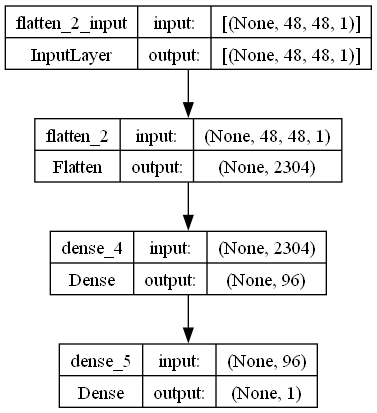

In [ ]:
# Summarize the model
model_v3.summary()
# Visualize the model
plot_model(model_v3, show_shapes=True, show_layer_names=True, rankdir='TB')

In [ ]:
evaluate_neural_network(model_v3, val_dataset_1, history_v4)

In [ ]:
# Predict the labels for the validation set
y_pred_probs = model_v3.predict(val_dataset_1)
y_pred = (y_pred_probs > 0.5).astype(int).reshape(-1)
# Extract true labels from the validation dataset
y_true = np.concatenate([np.array([y.numpy()]) for x, y in val_dataset_1.unbatch()], axis=0)

223/223 [==============================] - 32s 144ms/step


In [ ]:
# Print the classification report for all metrics
print(classification_report(y_true, y_pred, target_names=['Class 0', 'Class 1']))

# Calculate and print the accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

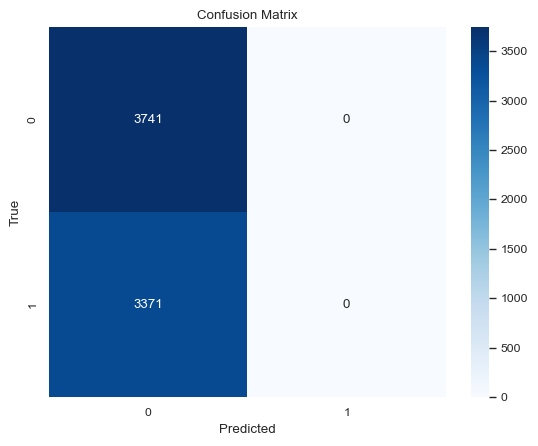

In [ ]:
# Assuming y_true and y_pred are available
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

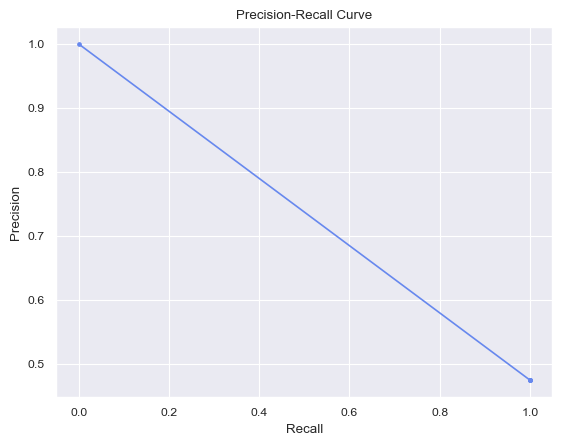

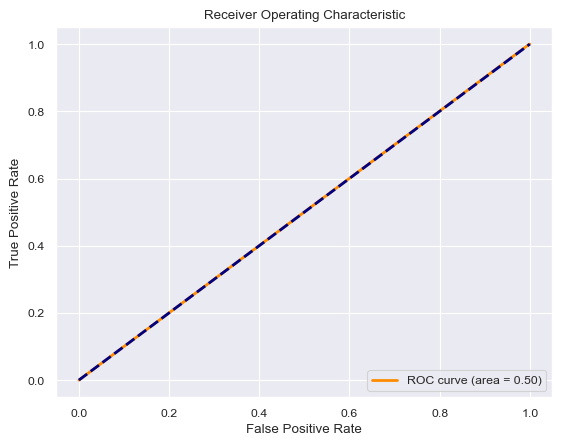

In [ ]:
from sklearn.metrics import precision_recall_curve, roc_curve, auc
import matplotlib.pyplot as plt

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_true, y_pred_probs)
plt.plot(recall, precision, marker='.')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


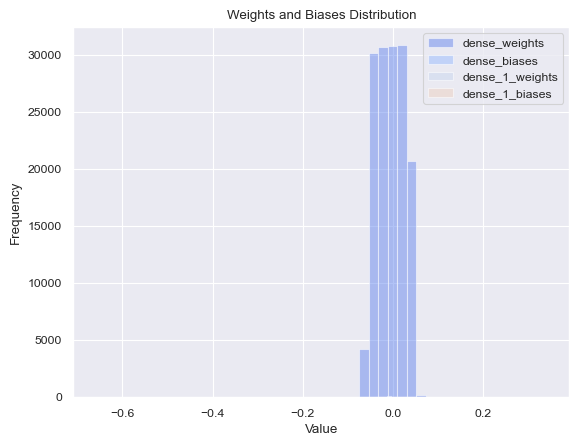

In [ ]:
for layer in model.layers:
    if 'dense' in layer.name:
        weights, biases = layer.get_weights()
        plt.hist(weights.flatten(), alpha=0.5, label=f'{layer.name}_weights')
        plt.hist(biases.flatten(), alpha=0.5, label=f'{layer.name}_biases')
plt.legend()
plt.title('Weights and Biases Distribution')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()


In [ ]:
# Example usage:
calculate_combined_misclassification_info(
    y_true, 
    y_pred, 
    age_gender_data, 
    category_names=['age', 'ethnicity', 'gender']
)


age - Misclassification rates:
  0-4: Total = 1605, Misclassified = 771 (48.04%)
  10-14: Total = 589, Misclassified = 289 (49.07%)
  100-104: Total = 14, Misclassified = 7 (50.00%)
  105-109: Total = 5, Misclassified = 3 (60.00%)
  110-114: Total = 6, Misclassified = 3 (50.00%)
  115-119: Total = 7, Misclassified = 5 (71.43%)
  15-19: Total = 942, Misclassified = 440 (46.71%)
  20-24: Total = 2310, Misclassified = 1096 (47.45%)
  25-29: Total = 1634, Misclassified = 757 (46.33%)

age - Misclassification distribution:
  0-4: Misclassified = 771 (22.87%) of Total Misclassified = 3371
  10-14: Misclassified = 289 (8.57%) of Total Misclassified = 3371
  100-104: Misclassified = 7 (0.21%) of Total Misclassified = 3371
  105-109: Misclassified = 3 (0.09%) of Total Misclassified = 3371
  110-114: Misclassified = 3 (0.09%) of Total Misclassified = 3371
  115-119: Misclassified = 5 (0.15%) of Total Misclassified = 3371
  15-19: Misclassified = 440 (13.05%) of Total Misclassified = 3371
  20-2

## 10. We train our first RESNET Neural Network. Model 4

In [ ]:
def residual_block(x, filters, conv_size, stride, is_identity=True):
    """Builds a residual block with skip connections."""
    shortcut = x
    # First convolution layer
    x = layers.Conv2D(filters, conv_size, strides=stride, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    # Second convolution layer
    x = layers.Conv2D(filters, conv_size, strides=1, padding='same')(x)
    x = layers.BatchNormalization()(x)

    # Add the shortcut to the output of the convolution block
    if not is_identity:
        shortcut = layers.Conv2D(filters, conv_size, strides=stride, padding='same')(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    x = layers.add([x, shortcut])
    x = layers.Activation('relu')(x)

    return x

def build_resnet(input_shape, num_classes=1, layer_list=[2, 2, 2, 2]):
    """Builds a ResNet model."""
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(64, (7, 7), strides=2, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((3, 3), strides=2, padding='same')(x)

    # Add the residual blocks
    for i, num_blocks in enumerate(layer_list):
        for j in range(num_blocks):
            if j == 0 and i != 0:
                x = residual_block(x, 64 * 2**i, (3, 3), stride=2, is_identity=False)
            else:
                x = residual_block(x, 64 * 2**i, (3, 3), stride=1)

    x = layers.GlobalAveragePooling2D()(x)
    
    outputs = layers.Dense(num_classes, activation='sigmoid')(x)  # For binary classification.
    model = models.Model(inputs=inputs, outputs=outputs)
    return model

In [ ]:
# Build the ResNet model
input_shape = (48, 48, 1)  # Adjust if your preprocessing changes the input shape.
model_v4 = build_resnet(input_shape)

# Compile the model
model_v4.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Summarize the model
model_v4.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 48, 48, 1)]  0           []                               
                                                                                                  
 conv2d_45 (Conv2D)             (None, 24, 24, 64)   3200        ['input_3[0][0]']                
                                                                                                  
 batch_normalization_45 (BatchN  (None, 24, 24, 64)  256         ['conv2d_45[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_38 (Activation)     (None, 24, 24, 64)   0           ['batch_normalization_45[0]

In [ ]:
# Visualize the model
plot_model(model_v4, show_shapes=True, show_layer_names=True, rankdir='TB')

In [ ]:
# Train the model on your dataset
start_time = time.time()
history_v5 = model_v4.fit(train_dataset_1, 
                         epochs=30, 
                         validation_data=val_dataset_1,
                         callbacks=[es_callback, modelckpt_callback])
end_time = time.time()

Epoch 1/30


517/519 [============================>.] - ETA: 0s - loss: 0.4121 - accuracy: 0.8086
Epoch 1: val_loss did not improve from 0.26359
519/519 [==============================] - 126s 85ms/step - loss: 0.4120 - accuracy: 0.8086 - val_loss: 0.3806 - val_accuracy: 0.8241
Epoch 2/30
519/519 [==============================] - ETA: 0s - loss: 0.3057 - accuracy: 0.8647
Epoch 2: val_loss did not improve from 0.26359
519/519 [==============================] - 127s 85ms/step - loss: 0.3057 - accuracy: 0.8647 - val_loss: 0.4891 - val_accuracy: 0.7795
Epoch 3/30
516/519 [============================>.] - ETA: 0s - loss: 0.2743 - accuracy: 0.8778
Epoch 3: val_loss did not improve from 0.26359
519/519 [==============================] - 129s 84ms/step - loss: 0.2742 - accuracy: 0.8778 - val_loss: 0.3497 - val_accuracy: 0.8573
Epoch 4/30
518/519 [============================>.] - ETA: 0s - loss: 0.2464 - accuracy: 0.8936
Epoch 4: val_loss did not improve from 0.26359
519/519 [============================

In [ ]:
# Calculate and print the duration
duration_mins = (end_time - start_time)/60
print(f'{Back.RED}Training completed in (mins):{Back.RESET}',
    f"\n{Back.BLUE}{duration_mins:.3f}{Back.RESET}")

Training completed in (mins): 
18.588


In [ ]:
evaluate_neural_network(model_v4, val_dataset_1, history_v5)

In [ ]:
# Predict the labels for the validation set
y_pred_probs = model_v4.predict(val_dataset_1)
y_pred = (y_pred_probs > 0.5).astype(int).reshape(-1)
# Extract true labels from the validation dataset
y_true = np.concatenate([np.array([y.numpy()]) for x, y in val_dataset_1.unbatch()], axis=0)

223/223 [==============================] - 33s 147ms/step


In [ ]:
# Print the classification report for all metrics
print(classification_report(y_true, y_pred, target_names=['Class 0', 'Class 1']))

# Calculate and print the accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

              precision    recall  f1-score   support

     Class 0       0.92      0.82      0.87      3741
     Class 1       0.83      0.92      0.87      3371

    accuracy                           0.87      7112
   macro avg       0.87      0.87      0.87      7112
weighted avg       0.88      0.87      0.87      7112

Accuracy: 87.09%


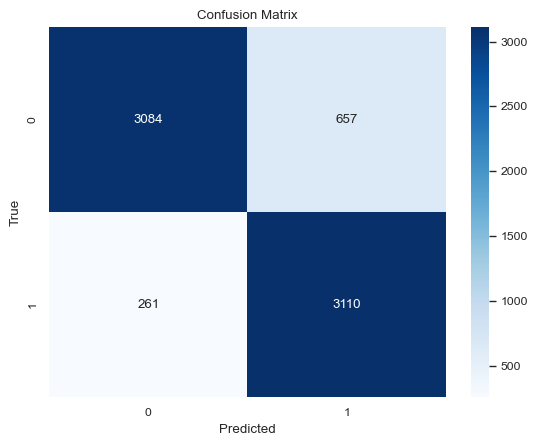

In [ ]:
# Assuming y_true and y_pred are available
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

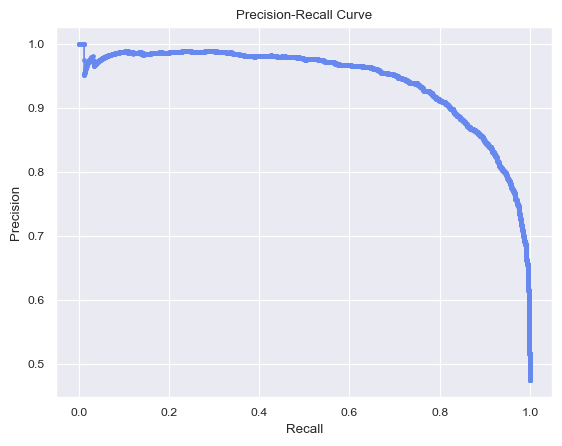

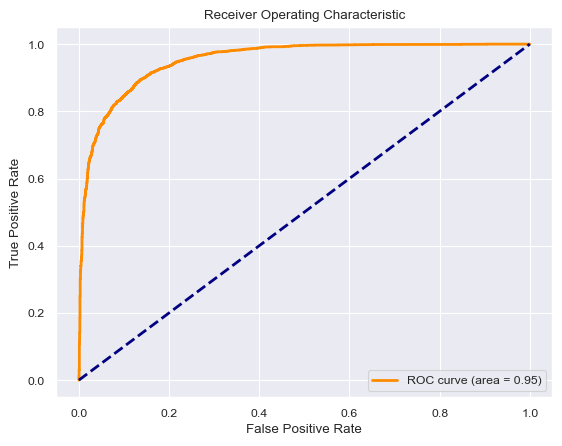

In [ ]:
from sklearn.metrics import precision_recall_curve, roc_curve, auc
import matplotlib.pyplot as plt

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_true, y_pred_probs)
plt.plot(recall, precision, marker='.')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


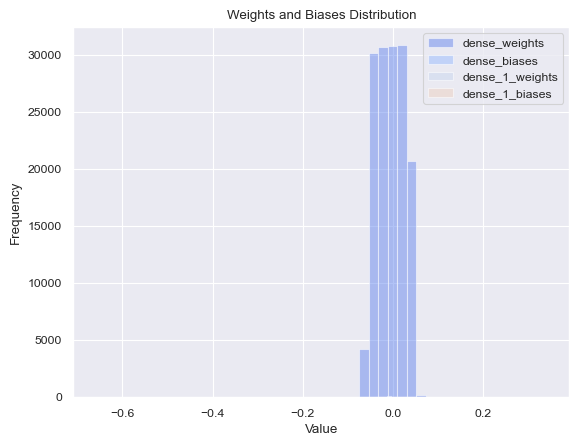

In [ ]:
for layer in model.layers:
    if 'dense' in layer.name:
        weights, biases = layer.get_weights()
        plt.hist(weights.flatten(), alpha=0.5, label=f'{layer.name}_weights')
        plt.hist(biases.flatten(), alpha=0.5, label=f'{layer.name}_biases')
plt.legend()
plt.title('Weights and Biases Distribution')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()


In [ ]:
# Example usage:
calculate_combined_misclassification_info(
    y_true, 
    y_pred, 
    age_gender_data, 
    category_names=['age', 'ethnicity', 'gender']
)


age - Misclassification rates:
  0-4: Total = 1605, Misclassified = 196 (12.21%)
  10-14: Total = 589, Misclassified = 80 (13.58%)
  100-104: Total = 14, Misclassified = 1 (7.14%)
  105-109: Total = 5, Misclassified = 0 (0.00%)
  110-114: Total = 6, Misclassified = 0 (0.00%)
  115-119: Total = 7, Misclassified = 4 (57.14%)
  15-19: Total = 942, Misclassified = 143 (15.18%)
  20-24: Total = 2310, Misclassified = 279 (12.08%)
  25-29: Total = 1634, Misclassified = 215 (13.16%)

age - Misclassification distribution:
  0-4: Misclassified = 196 (21.35%) of Total Misclassified = 918
  10-14: Misclassified = 80 (8.71%) of Total Misclassified = 918
  100-104: Misclassified = 1 (0.11%) of Total Misclassified = 918
  105-109: Misclassified = 0 (0.00%) of Total Misclassified = 918
  110-114: Misclassified = 0 (0.00%) of Total Misclassified = 918
  115-119: Misclassified = 4 (0.44%) of Total Misclassified = 918
  15-19: Misclassified = 143 (15.58%) of Total Misclassified = 918
  20-24: Misclassif

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Assuming the DataProcessor class is already defined as you provided.

def residual_block(x, filters, conv_size, stride, is_identity=True):
    """Builds a residual block with skip connections."""
    shortcut = x
    # First convolution layer
    x = layers.Conv2D(filters, conv_size, strides=stride, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    # Second convolution layer
    x = layers.Conv2D(filters, conv_size, strides=1, padding='same')(x)
    x = layers.BatchNormalization()(x)

    # Add the shortcut to the output of the convolution block
    if not is_identity:
        shortcut = layers.Conv2D(filters, conv_size, strides=stride, padding='same')(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    x = layers.add([x, shortcut])
    x = layers.Activation('relu')(x)

    return x

def build_resnet_v2(input_shape, num_classes=1, layer_list=[2, 2, 2, 2, 2]):
    """Builds a ResNet model."""
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(64, (7, 7), strides=2, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((3, 3), strides=2, padding='same')(x)

    # Add the residual blocks
    for i, num_blocks in enumerate(layer_list):
        for j in range(num_blocks):
            if j == 0 and i != 0:
                x = residual_block(x, 64 * 2**i, (3, 3), stride=2, is_identity=False)
            else:
                x = residual_block(x, 64 * 2**i, (3, 3), stride=1)

    x = layers.GlobalAveragePooling2D()(x)
    
    outputs = layers.Dense(num_classes, activation='sigmoid')(x)  # For binary classification.
    model = models.Model(inputs=inputs, outputs=outputs)
    return model

In [ ]:
# Build the ResNet model
input_shape = (48, 48, 1)  # Adjust if your preprocessing changes the input shape.
model_resnet_v2 = build_resnet_v2(input_shape)
# You can define multiple metrics and Keras Tuner will consider the first one for optimization
metrics = [keras.metrics.BinaryAccuracy(threshold=0.5),
               keras.metrics.AUC()]
# Compile the model
model_resnet_v2.compile(optimizer='adam', loss='binary_crossentropy', metrics=metrics)

In [ ]:
# Train the model on your dataset
start_time = time.time()
history_v5 = model_resnet_v2.fit(train_dataset_1, 
                         epochs=30, 
                         validation_data=val_dataset_1,
                         callbacks=[es_callback, modelckpt_callback])
end_time = time.time()

Epoch 1/30


519/519 [==============================] - ETA: 0s - loss: 0.5022 - binary_accuracy: 0.7783 - auc_4: 0.8595
Epoch 1: val_loss did not improve from 0.26359
519/519 [==============================] - 139s 105ms/step - loss: 0.5022 - binary_accuracy: 0.7783 - auc_4: 0.8595 - val_loss: 0.3836 - val_binary_accuracy: 0.8261 - val_auc_4: 0.9100
Epoch 2/30
519/519 [==============================] - ETA: 0s - loss: 0.3692 - binary_accuracy: 0.8335 - auc_4: 0.9162
Epoch 2: val_loss did not improve from 0.26359
519/519 [==============================] - 133s 105ms/step - loss: 0.3692 - binary_accuracy: 0.8335 - auc_4: 0.9162 - val_loss: 0.3714 - val_binary_accuracy: 0.8335 - val_auc_4: 0.9226
Epoch 3/30
518/519 [============================>.] - ETA: 0s - loss: 0.3097 - binary_accuracy: 0.8627 - auc_4: 0.9415
Epoch 3: val_loss did not improve from 0.26359
519/519 [==============================] - 135s 107ms/step - loss: 0.3096 - binary_accuracy: 0.8628 - auc_4: 0.9415 - val_loss: 0.3133 - val_bi

In [ ]:
# Calculate and print the duration
duration_mins = (end_time - start_time)/60
print(f'{Back.RED}Training completed in (mins):{Back.RESET}',
    f"\n{Back.BLUE}{duration_mins:.3f}{Back.RESET}")

Training completed in (mins): 
29.330


In [ ]:
# Predict the labels for the validation set
y_pred_probs = model_v4.predict(val_dataset_1)
y_pred = (y_pred_probs > 0.5).astype(int).reshape(-1)
# Extract true labels from the validation dataset
y_true = np.concatenate([np.array([y.numpy()]) for x, y in val_dataset_1.unbatch()], axis=0)

223/223 [==============================] - 35s 157ms/step


In [ ]:
# Print the classification report for all metrics
print(classification_report(y_true, y_pred, target_names=['Class 0', 'Class 1']))

# Calculate and print the accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

              precision    recall  f1-score   support

     Class 0       0.92      0.82      0.87      3741
     Class 1       0.83      0.92      0.87      3371

    accuracy                           0.87      7112
   macro avg       0.87      0.87      0.87      7112
weighted avg       0.88      0.87      0.87      7112

Accuracy: 87.09%


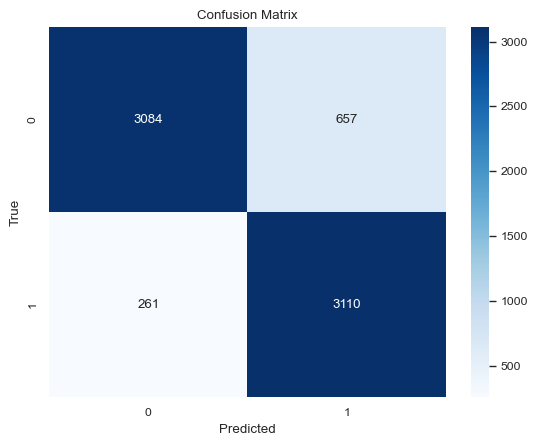

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Assuming y_true and y_pred are available
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

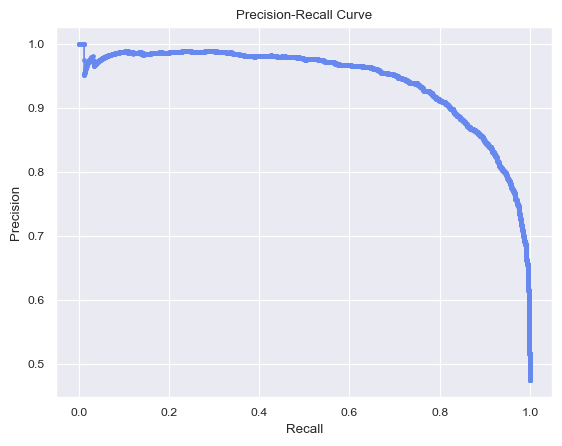

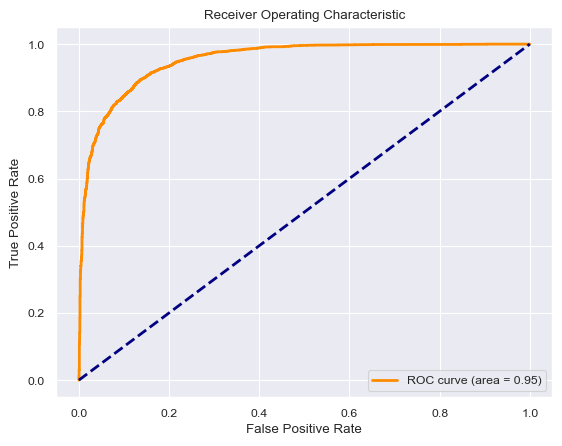

In [ ]:
from sklearn.metrics import precision_recall_curve, roc_curve, auc
import matplotlib.pyplot as plt

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_true, y_pred_probs)
plt.plot(recall, precision, marker='.')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


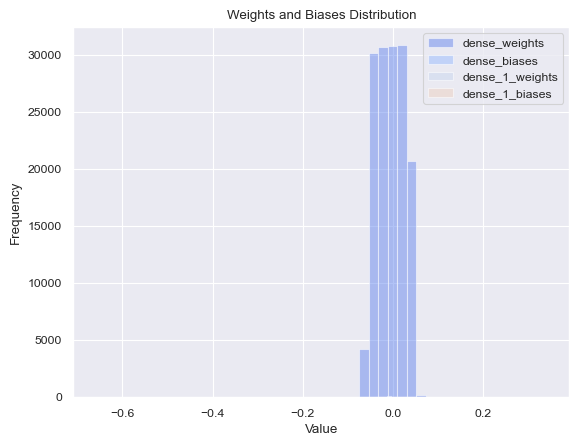

In [ ]:
for layer in model.layers:
    if 'dense' in layer.name:
        weights, biases = layer.get_weights()
        plt.hist(weights.flatten(), alpha=0.5, label=f'{layer.name}_weights')
        plt.hist(biases.flatten(), alpha=0.5, label=f'{layer.name}_biases')
plt.legend()
plt.title('Weights and Biases Distribution')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()


In [ ]:
# Example usage:
calculate_combined_misclassification_info(
    y_true, 
    y_pred, 
    age_gender_data, 
    category_names=['age', 'ethnicity', 'gender']
)


age - Misclassification rates:
  0-4: Total = 1605, Misclassified = 196 (12.21%)
  10-14: Total = 589, Misclassified = 80 (13.58%)
  100-104: Total = 14, Misclassified = 1 (7.14%)
  105-109: Total = 5, Misclassified = 0 (0.00%)
  110-114: Total = 6, Misclassified = 0 (0.00%)
  115-119: Total = 7, Misclassified = 4 (57.14%)
  15-19: Total = 942, Misclassified = 143 (15.18%)
  20-24: Total = 2310, Misclassified = 279 (12.08%)
  25-29: Total = 1634, Misclassified = 215 (13.16%)

age - Misclassification distribution:
  0-4: Misclassified = 196 (21.35%) of Total Misclassified = 918
  10-14: Misclassified = 80 (8.71%) of Total Misclassified = 918
  100-104: Misclassified = 1 (0.11%) of Total Misclassified = 918
  105-109: Misclassified = 0 (0.00%) of Total Misclassified = 918
  110-114: Misclassified = 0 (0.00%) of Total Misclassified = 918
  115-119: Misclassified = 4 (0.44%) of Total Misclassified = 918
  15-19: Misclassified = 143 (15.58%) of Total Misclassified = 918
  20-24: Misclassif